In [1]:
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
#%matplotlib inline
#import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/clean_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

County  num_tracts  n_food_des  n_urban  n_rural  urban_des  rural_des  \
0    Alameda       360.0        15.0    354.0      6.0       15.0        0.0   
1     Alpine         1.0         0.0      0.0      1.0        0.0        0.0   
2     Amador         9.0         0.0      0.0      9.0        0.0        0.0   
3      Butte        51.0        14.0     38.0     13.0       13.0        1.0   
4  Calaveras        10.0         0.0      2.0      8.0        0.0        0.0   

      Rural     Urban  LILATracts_1And10       ...        \
0  0.016667  0.983333           0.041667       ...         
1  1.000000  0.000000           0.000000       ...         
2  1.000000  0.000000           0.000000       ...         
3  0.254902  0.745098           0.274510       ...         
4  0.800000  0.200000           0.000000       ...         

   Varicella Hospitalizations  opiods_rx_1000  opiods_greater_than_stateavg  \
0                       0.132          557.20                             0   
1                       0.000          578.68                             0   
2                       0.000         1244.76                             1   
3                       0.455         1389.20                             1   
4                       0.000         1068.98                             1   

   MILK_PRICE10  SODA_PRICE10  MILK_SODA_PRICE10  PCH_FFR_07_12   FFR07  \
0      1.122215      1.164422           0.891575       8.902878  1112.0   
1      1.032918      1.089488           0.877073     -50.000000     2.0   
2      1.032918      1.089488           0.877073      -5.555556    18.0   
3      0.996443      1.130546           0.815374       2.684564   149.0   
4      1.032918      1.089488           0.877073      -7.407407    27.0   

   FFR12  pop2010_in_des  
0   1211         56082.0  
1      1             NaN  
2     17             NaN  
3    153         58979.0  
4     25             NaN  

[5 rows x 75 columns]

In [4]:

def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

In [5]:
df.columns.tolist()
grouped = df.groupby('high_food_des_prev')
food_des = grouped.get_group(1)
non_food_des = grouped.get_group(0)

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 75 columns):
County                                58 non-null object
num_tracts                            58 non-null float64
n_food_des                            58 non-null float64
n_urban                               58 non-null float64
n_rural                               58 non-null float64
urban_des                             58 non-null float64
rural_des                             58 non-null float64
Rural                                 58 non-null float64
Urban                                 58 non-null float64
LILATracts_1And10                     58 non-null float64
high_food_des_prev                    58 non-null float64
cnty_obesity_pct                      58 non-null float64
cnty_obesity_pct_adj                  58 non-null float64
cnty_dm_pct                           58 non-null float64
cnty_dm_pct_adj                       58 non-null float64
cnty_inactive_pct           

https://chhs.data.ca.gov/Demographics/Medical-Service-Study-Areas-2010/s6uk-kn8j

## Geospatial Visualization

In [7]:
mssa = pd.read_csv('/Users/desert/downloads/Medical_Service_Study_Areas__2010.csv')
mssa = mssa[['CNTY_FIPS','COUNTY']]#,'UNIT_COUNT','MSSA_ID','DEFINITION','POP']]
mssa.columns = [x.title() for x in mssa.columns]
mssa = mssa.drop_duplicates()
df = pd.merge(df,mssa,how='inner', on='County')


In [8]:
from bokeh.models import HoverTool
#from bokeh.palettes import Viridis6
from bokeh.plotting import figure, show, ColumnDataSource, output_file
import bokeh.sampledata
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.sampledata.us_states import data as states

#bokeh.sampledata.download()


In [9]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [10]:
counties = {
    code: county for code, county in counties.items() if county["state"] == "ca"
}

colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]
county_rates = [unemployment[county_id] for county_id in counties]

county_colors = [colors[int(rate/6)] for rate in county_rates]

data=dict(
    x=county_xs,
    y=county_ys,
    color=county_colors,
    name=county_names,
    rate=county_rates,
)


data = pd.DataFrame(data)
data.head()
data.rename(columns={'name':'County'}, inplace=True)
c= pd.merge(data, df[['n_food_des','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'n_food_des' : 'rate'}, inplace=True)

def quantile(col, q=[0,0.25,0.5,0.75,1]):
    colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
    q0,q1,q2,q3,q4 = col.quantile(q)
    vals = [val for val in col]
    rate = []
    for elem in vals:
        if elem == q4:
            rate.append(colors[5])
        if elem < q4 and elem >= q3:
            rate.append(colors[4])
        if elem < q3 and elem >= q2:
            rate.append(colors[3])
        if elem < q2 and elem >= q1:
            rate.append(colors[2])
        if elem < q1:
            rate.append(colors[0])
    return rate
    

c['prev'] = quantile(c['rate'])
c.head()

color           name  unem  \
0  #C994C7           Yuba  17.8   
1  #C994C7      Calaveras  14.3   
2  #C994C7         Madera  12.3   
3  #D4B9DA         Placer  11.3   
4  #D4B9DA  San Francisco   9.7   

                                                   x  \
0  [-121.23727, -121.161, -121.11582, -121.07669,...   
1  [-120.0819, -120.08198, -120.12248, -120.16929...   
2  [-120.45364, -120.49976, -120.53843, -120.5417...   
3  [-120.55531, -120.55503, -120.32616, -120.1178...   
4  [-123.00111, -122.99754, -122.99509, -122.9874...   

                                                   y  rate  LILATracts_1And10  \
0  [39.52657, 39.51954, 39.5671, 39.59726, 39.597...   4.0           0.285714   
1  [38.40885, 38.40873, 38.39886, 38.37713, 38.35...   0.0           0.000000   
2  [36.88008, 36.98496, 37.02421, 37.0445, 37.044...   2.0           0.086957   
3  [39.31561, 39.31557, 39.31644, 39.31628, 39.31...   6.0           0.070588   
4  [37.77205, 37.77078, 37.76913, 37.76387, 37.75...  10.0           0.051020   

      prev  
0  #C994C7  
1  #F1EEF6  
2  #C994C7  
3  #DF65B0  
4  #DD1C77

In [11]:
c[c['name'] == 'Fresno']

color    name  unem                                                  x  \
43  #C994C7  Fresno  14.1  [-120.65159, -120.63665, -120.6274, -120.59122...   

                                                    y  rate  \
43  [36.9528, 36.95272, 36.9528, 36.95264, 36.9728...  31.0   

    LILATracts_1And10     prev  
43           0.155779  #DD1C77

In [12]:
source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"
p = figure(title="CA Coutnies: Food Deserts counts 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Food Deserts)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

Loading BokehJS ...

In [14]:
show(p)

In [15]:
c= pd.merge(data, df[['des_percent','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'des_percent' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="CA Number Food Deserts / Total Counties: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Food Deserts)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

Loading BokehJS ...

http://www.chcf.org/oscn/data

In [16]:
# op = pd.read_excel('/Users/desert/desert_workspace/desert_data/OpioidSafetyData/Prescription_Data_byCounty_2010-13_OpioidSafetyCoalitions_run041216.xlsx', sheet=1)
# op.head()

In [17]:
# op=op[['County','2010 \n# of opioid prescriptions per 1000 residents per year \n(excl bupe)']]
# op.columns = ['County', 'opiods_rx_1000']
# op.head()

In [18]:
# mask = op['County'].isin(df['County'])
# op = op[mask]
# df = pd.merge(df,op,how='inner',on='County')
# df.head()

In [19]:
c= pd.merge(data, df[['opiods_rx_1000','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'opiods_rx_1000' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="CA Opiod Rx's per 1000 Residents By County: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Opioid rx per 1000 residents per yr)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

Loading BokehJS ...

In [21]:
df.tail(15)#1254.24
df[df['County'] == 'Siskiyou']

County  num_tracts  n_food_des  n_urban  n_rural  urban_des  rural_des  \
46  Siskiyou        14.0         5.0      3.0     11.0        1.0        4.0   

       Rural     Urban  LILATracts_1And10    ...      opiods_rx_1000  \
46  0.785714  0.214286           0.357143    ...             1254.24   

    opiods_greater_than_stateavg  MILK_PRICE10  SODA_PRICE10  \
46                             1      0.996443      1.130546   

    MILK_SODA_PRICE10  PCH_FFR_07_12  FFR07  FFR12  pop2010_in_des  Cnty_Fips  
46           0.815374      -3.448276   29.0     28         12609.0         93  

[1 rows x 76 columns]

In [22]:
inf = pd.read_csv('/Users/workspace/food_desert_data/Infectious_Disease_Cases_by_County__Year__and_Sex__2001-2014.csv')
inf = inf[(inf['Year'] == 2010) & (inf['County']!='California')]
inf = inf[inf['Sex'] == 'Total']
inf
# grouped=inf.groupby(['County','Disease']).agg(np.mean)[['Count', 'Rate']].reset_index()
# inf_counts=grouped.pivot(index='County', columns='Disease', values='Count').reset_index()
# inf_rates=grouped.pivot(index='County', columns='Disease', values='Rate').reset_index()
# drop = inf_rates.columns.tolist()[1:]

Disease           County  Year    Sex  Count  Population   Rate  \
69        Amebiasis          Alameda  2010  Total     24     1513734  1.585   
111       Amebiasis           Alpine  2010  Total      0        1163  0.000   
153       Amebiasis           Amador  2010  Total      0       37863  0.000   
195       Amebiasis            Butte  2010  Total      0      219971  0.000   
237       Amebiasis        Calaveras  2010  Total      0       45456  0.000   
279       Amebiasis           Colusa  2010  Total      0       21483  0.000   
321       Amebiasis     Contra Costa  2010  Total     11     1052199  1.045   
363       Amebiasis        Del Norte  2010  Total      0       28543  0.000   
405       Amebiasis        El Dorado  2010  Total      0      180925  0.000   
447       Amebiasis           Fresno  2010  Total      0      932343  0.000   
489       Amebiasis            Glenn  2010  Total      0       28144  0.000   
531       Amebiasis         Humboldt  2010  Total      1      134656  0.743   
573       Amebiasis         Imperial  2010  Total      1      175424  0.570   
615       Amebiasis             Inyo  2010  Total      0       18530  0.000   
657       Amebiasis             Kern  2010  Total      1      841158  0.119   
699       Amebiasis            Kings  2010  Total      0      152693  0.000   
741       Amebiasis             Lake  2010  Total      0       64602  0.000   
783       Amebiasis           Lassen  2010  Total      0       35145  0.000   
825       Amebiasis      Los Angeles  2010  Total    130     9826799  1.323   
867       Amebiasis           Madera  2010  Total      0      151318  0.000   
910       Amebiasis            Marin  2010  Total      4      252698  1.583   
952       Amebiasis         Mariposa  2010  Total      0       18194  0.000   
994       Amebiasis        Mendocino  2010  Total      0       87917  0.000   
1036      Amebiasis           Merced  2010  Total      0      255886  0.000   
1077      Amebiasis            Modoc  2010  Total      0        9649  0.000   
1119      Amebiasis             Mono  2010  Total      0       14234  0.000   
1161      Amebiasis         Monterey  2010  Total      0      416263  0.000   
1203      Amebiasis             Napa  2010  Total      0      136811  0.000   
1245      Amebiasis           Nevada  2010  Total      1       98625  1.014   
1287      Amebiasis           Orange  2010  Total     16     3017248  0.530   
...             ...              ...   ...    ...    ...         ...    ...   
140544  Yersiniosis           Nevada  2010  Total      0       98625  0.000   
140586  Yersiniosis           Orange  2010  Total     10     3017248  0.331   
140628  Yersiniosis           Placer  2010  Total      0      350272  0.000   
140670  Yersiniosis           Plumas  2010  Total      0       19904  0.000   
140712  Yersiniosis        Riverside  2010  Total      2     2191919  0.091   
140754  Yersiniosis       Sacramento  2010  Total      0     1420255  0.000   
140796  Yersiniosis       San Benito  2010  Total      0       55332  0.000   
140838  Yersiniosis   San Bernardino  2010  Total      1     2038518  0.049   
140880  Yersiniosis        San Diego  2010  Total     15     3102904  0.483   
140922  Yersiniosis    San Francisco  2010  Total      2      806314  0.248   
140964  Yersiniosis      San Joaquin  2010  Total      2      686576  0.291   
141006  Yersiniosis  San Luis Obispo  2010  Total      0      269677  0.000   
141048  Yersiniosis        San Mateo  2010  Total      3      719667  0.417   
141090  Yersiniosis    Santa Barbara  2010  Total      0      424020  0.000   
141132  Yersiniosis      Santa Clara  2010  Total      0     1786533  0.000   
141174  Yersiniosis       Santa Cruz  2010  Total      0      263182  0.000   
141216  Yersiniosis           Shasta  2010  Total      0      177457  0.000   
141258  Yersiniosis           Sierra  2010  Total      0        3229  0.000   
141300  Yersiniosis         Siskiyou  2010  Total      0      

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


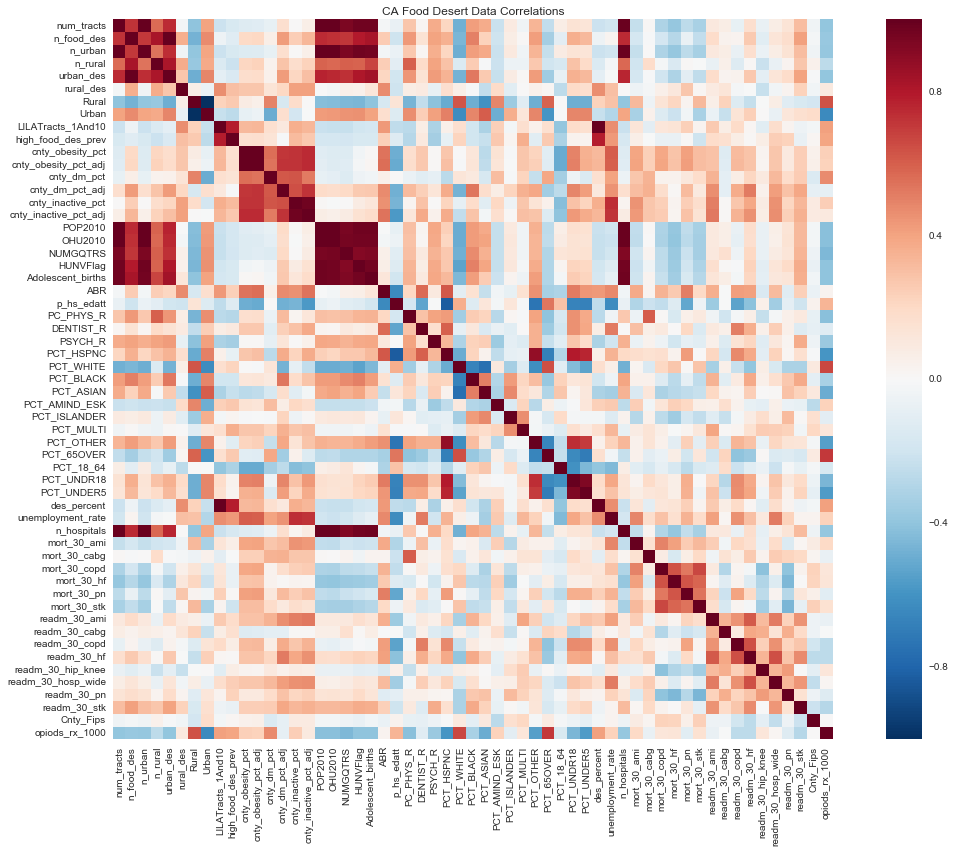

In [22]:

keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [23]:
df[['County','POP2010','des_percent', 'num_tracts','n_food_des']]
affected = (df['POP2010'] * df['des_percent'])
df['pop2010_in_des'] = affected
df['pop2010_in_des'] = df['pop2010_in_des'].astype(int)
df[['County','POP2010','pop2010_in_des','des_percent', 'num_tracts','n_food_des']]
#df[keep].columns.tolist()

County  POP2010  pop2010_in_des  des_percent  num_tracts  \
0           Alameda  1510271           62927     0.041667       360.0   
1            Alpine     1175               0     0.000000         1.0   
2            Amador    38091               0     0.000000         9.0   
3             Butte   220000           60392     0.274510        51.0   
4         Calaveras    45578               0     0.000000        10.0   
5            Colusa    21419            4283     0.200000         5.0   
6      Contra Costa  1049025           75650     0.072115       208.0   
7         Del Norte    28610           12261     0.428571         7.0   
8         El Dorado   181058           12631     0.069767        43.0   
9            Fresno   930450          144944     0.155779       199.0   
10            Glenn    28122           14061     0.500000         6.0   
11         Humboldt   134623           35899     0.266667        30.0   
12         Imperial   174528           50669     0.290323        31.0   
13             Inyo    18546            3091     0.166667         6.0   
14             Kern   839631          116769     0.139073       151.0   
15            Kings   152982           39661     0.259259        27.0   
16             Lake    64665               0     0.000000        15.0   
17           Lassen    34895            7754     0.222222         9.0   
18      Los Angeles  9818605          272389     0.027742      2343.0   
19           Madera   150865           13118     0.086957        23.0   
20            Marin   252409            4589     0.018182        55.0   
21         Mariposa    18251               0     0.000000         6.0   
22        Mendocino    87841           21960     0.250000        20.0   
23           Merced   255793           52202     0.204082        49.0   
24            Modoc     9686            7264     0.750000         4.0   
25             Mono    14202               0     0.000000         3.0   
26         Monterey   415057           31240     0.075269        93.0   
27             Napa   136484               0     0.000000        40.0   
28           Nevada    98764           14814     0.150000        20.0   
29           Orange  3010232           30980     0.010292       583.0   
30           Placer   348432           24595     0.070588        85.0   
31           Plumas    20007            2858     0.142857         7.0   
32        Riverside  2189641          261016     0.119205       453.0   
33       Sacramento  1418788          111891     0.078864       317.0   
34       San Benito    55269           10048     0.181818        11.0   
35   San Bernardino  2035210          352990     0.173442       369.0   
36        San Diego  3095313          108434     0.035032       628.0   
37    San Francisco   805235           41083     0.051020       196.0   
38      San Joaquin   685306           34511     0.050360       139.0   
39  San Luis Obispo   269637           10174     0.037736        53.0   
40        San Mateo   718451           13641     0.018987       158.0   
41    Santa Barbara   423895           14129     0.033333        90.0   
42      Santa Clara  1781642           67051     0.037634       372.0   
43       Santa Cruz   262382           20183     0.076923        52.0   
44           Shasta   177223           33229     0.187500        48.0   
45           Sierra     3240               0     0.000000         1.0   
46         Siskiyou    44900           16035     0.357143        14.0   
47           Solano   413344           30139     0.072917        96.0   
48           Sonoma   483878           34213     0.070707        99.0   
49       Stanislaus   514453           65674     0.127660        94.0   
50           Sutter    94737           22556     0.238095        21.0   
51           Tehama    63463           28846     0.454545        11.0   
52          Trinity    13786            5514     0.400000         5.0   
53           Tulare   442179           79365     0.179487        78.0  

In [24]:
pops=pd.read_excel('/Users/workspace/PycharmProjects/desert/desert_data/food_desert.xlsx',sheetname=2)
cols = pops.columns.tolist()


In [25]:
subset = ['CensusTract','State','County','POP2010','Rural','Urban','LILATracts_1And10']
pops = pops[pops['State']=='CA']
pops=pops[subset]
grouped = pops[['County','POP2010','Rural','Urban','LILATracts_1And10']].groupby(['County','LILATracts_1And10']).sum()
grouped = grouped.reset_index()
deserts = grouped[grouped['LILATracts_1And10']==1]
deserts=deserts[['County','POP2010']]
deserts.columns = ['County','pop2010_in_des']
deserts.head()

County  pop2010_in_des
1        Alameda           56082
5          Butte           58979
8         Colusa            6055
10  Contra Costa           77910
12     Del Norte            7023

In [26]:
df.columns.tolist()
df = df.drop('pop2010_in_des', axis=1)
df = pd.merge(df,deserts,how='left', on='County')
df.head()

County  num_tracts  n_food_des  n_urban  n_rural  urban_des  rural_des  \
0    Alameda       360.0        15.0    354.0      6.0       15.0        0.0   
1     Alpine         1.0         0.0      0.0      1.0        0.0        0.0   
2     Amador         9.0         0.0      0.0      9.0        0.0        0.0   
3      Butte        51.0        14.0     38.0     13.0       13.0        1.0   
4  Calaveras        10.0         0.0      2.0      8.0        0.0        0.0   

      Rural     Urban  LILATracts_1And10       ...        Tuberculosis  \
0  0.016667  0.983333           0.041667       ...              12.354   
1  1.000000  0.000000           0.000000       ...               0.000   
2  1.000000  0.000000           0.000000       ...               2.641   
3  0.254902  0.745098           0.274510       ...               0.909   
4  0.800000  0.200000           0.000000       ...               0.000   

   Tularemia  Typhoid Fever, case  Typhus Fever  Varicella Hospitalizations  \
0      0.000                0.727           0.0                       0.132   
1      0.000                0.000           0.0                       0.000   
2      0.000                0.000           0.0                       0.000   
3      0.455                0.000           0.0                       0.455   
4      0.000                0.000           0.0                       0.000   

   Vibrio Infection (non-Cholera)  Yersiniosis  Cnty_Fips  opiods_rx_1000  \
0                           0.528        0.264          1          557.20   
1                           0.000        0.000          3          578.68   
2                           0.000        0.000          5         1244.76   
3                           0.000        0.000          7         1389.20   
4                           0.000        0.000          9         1068.98   

   pop2010_in_des  
0         56082.0  
1             NaN  
2             NaN  
3         58979.0  
4             NaN  

[5 rows x 119 columns]

In [27]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df=order(df,['County','pop2010_in_des'])
df.head()

County  pop2010_in_des  num_tracts  n_food_des  n_urban  n_rural  \
0    Alameda         56082.0       360.0        15.0    354.0      6.0   
1     Alpine             NaN         1.0         0.0      0.0      1.0   
2     Amador             NaN         9.0         0.0      0.0      9.0   
3      Butte         58979.0        51.0        14.0     38.0     13.0   
4  Calaveras             NaN        10.0         0.0      2.0      8.0   

   urban_des  rural_des     Rural     Urban       ...        Trichinosis  \
0       15.0        0.0  0.016667  0.983333       ...                0.0   
1        0.0        0.0  1.000000  0.000000       ...                0.0   
2        0.0        0.0  1.000000  0.000000       ...                0.0   
3       13.0        1.0  0.254902  0.745098       ...                0.0   
4        0.0        0.0  0.800000  0.200000       ...                0.0   

   Tuberculosis  Tularemia  Typhoid Fever, case  Typhus Fever  \
0        12.354      0.000                0.727           0.0   
1         0.000      0.000                0.000           0.0   
2         2.641      0.000                0.000           0.0   
3         0.909      0.455                0.000           0.0   
4         0.000      0.000                0.000           0.0   

   Varicella Hospitalizations  Vibrio Infection (non-Cholera)  Yersiniosis  \
0                       0.132                           0.528        0.264   
1                       0.000                           0.000        0.000   
2                       0.000                           0.000        0.000   
3                       0.455                           0.000        0.000   
4                       0.000                           0.000        0.000   

   Cnty_Fips  opiods_rx_1000  
0          1          557.20  
1          3          578.68  
2          5         1244.76  
3          7         1389.20  
4          9         1068.98  

[5 rows x 119 columns]

In [28]:
df['pop2010_in_des'] = df['pop2010_in_des'].fillna(0)
df.head()

County  pop2010_in_des  num_tracts  n_food_des  n_urban  n_rural  \
0    Alameda         56082.0       360.0        15.0    354.0      6.0   
1     Alpine             0.0         1.0         0.0      0.0      1.0   
2     Amador             0.0         9.0         0.0      0.0      9.0   
3      Butte         58979.0        51.0        14.0     38.0     13.0   
4  Calaveras             0.0        10.0         0.0      2.0      8.0   

   urban_des  rural_des     Rural     Urban       ...        Trichinosis  \
0       15.0        0.0  0.016667  0.983333       ...                0.0   
1        0.0        0.0  1.000000  0.000000       ...                0.0   
2        0.0        0.0  1.000000  0.000000       ...                0.0   
3       13.0        1.0  0.254902  0.745098       ...                0.0   
4        0.0        0.0  0.800000  0.200000       ...                0.0   

   Tuberculosis  Tularemia  Typhoid Fever, case  Typhus Fever  \
0        12.354      0.000                0.727           0.0   
1         0.000      0.000                0.000           0.0   
2         2.641      0.000                0.000           0.0   
3         0.909      0.455                0.000           0.0   
4         0.000      0.000                0.000           0.0   

   Varicella Hospitalizations  Vibrio Infection (non-Cholera)  Yersiniosis  \
0                       0.132                           0.528        0.264   
1                       0.000                           0.000        0.000   
2                       0.000                           0.000        0.000   
3                       0.455                           0.000        0.000   
4                       0.000                           0.000        0.000   

   Cnty_Fips  opiods_rx_1000  
0          1          557.20  
1          3          578.68  
2          5         1244.76  
3          7         1389.20  
4          9         1068.98  

[5 rows x 119 columns]

In [29]:
c= pd.merge(data, df[['pop2010_in_des','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'pop2010_in_des' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="Number of Residents affected by Food Desert By County: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("number of residents living in food desert)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

Loading BokehJS ...

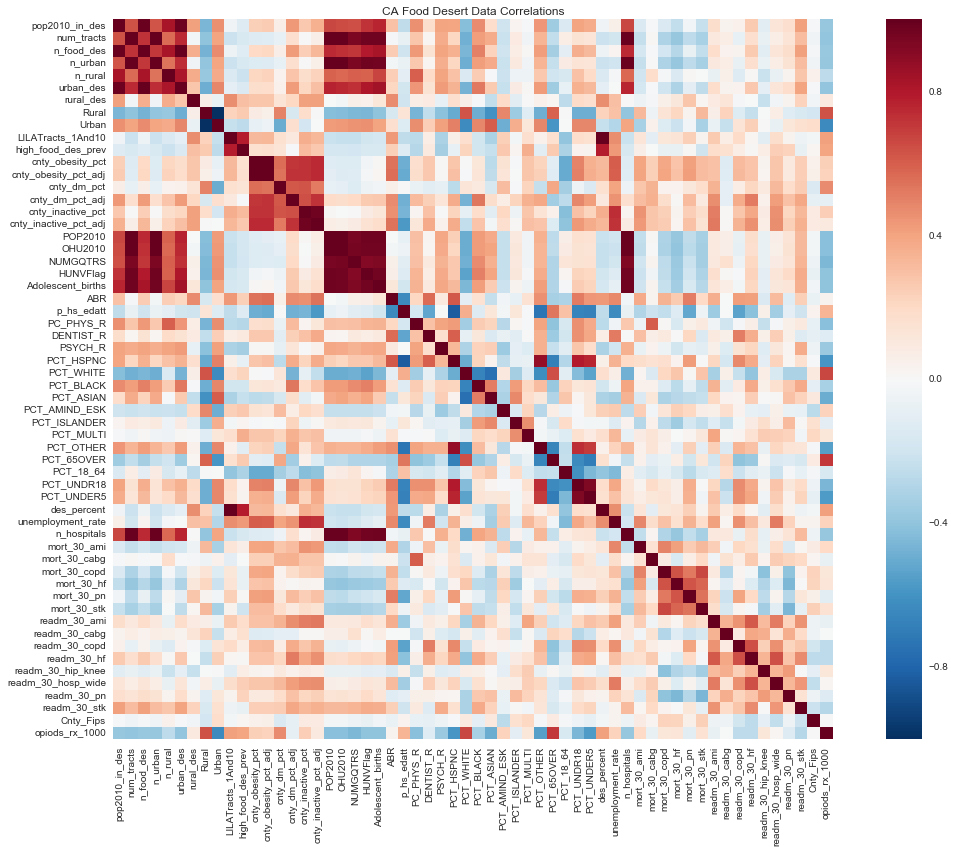

In [30]:
keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

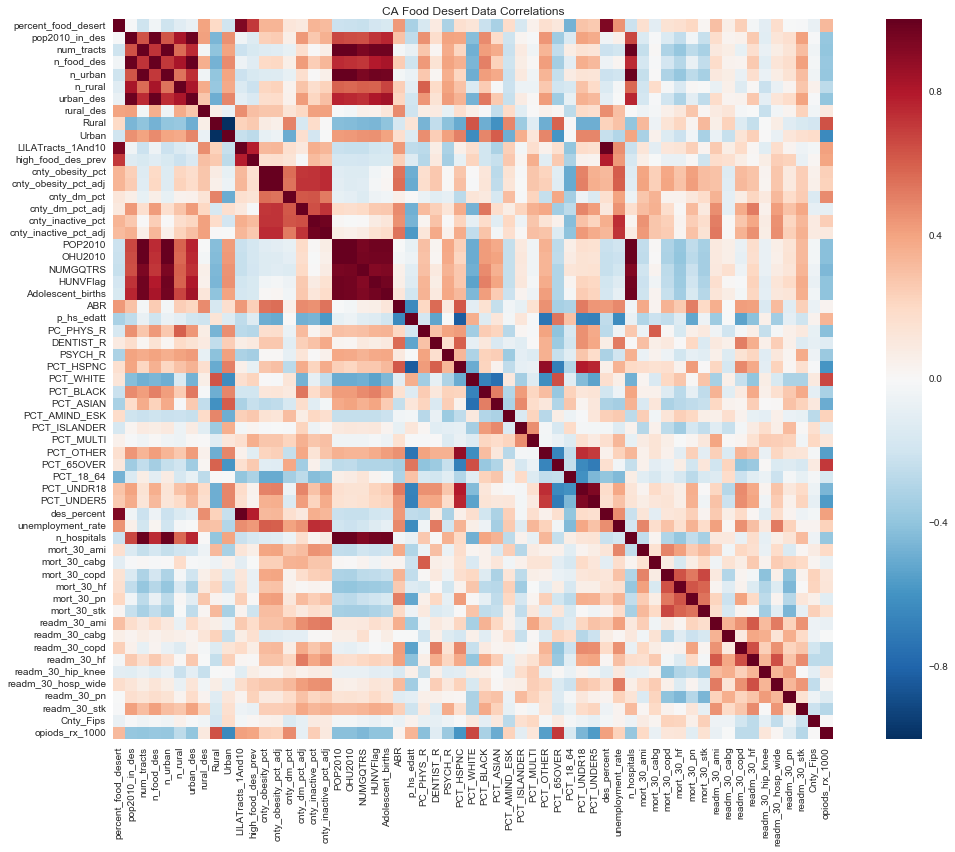

In [31]:
perc_in_des = df['pop2010_in_des'] / df['POP2010'] 
df['percent_food_desert'] = perc_in_des
df=order(df,['County','percent_food_desert'])
keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

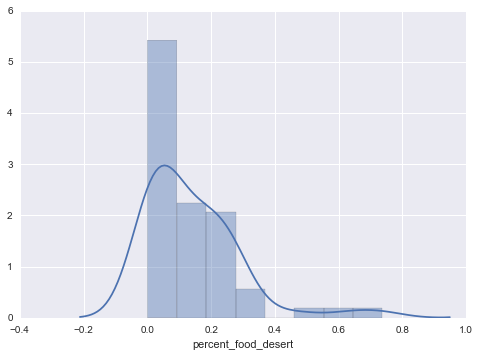

In [32]:
sns.distplot(df['percent_food_desert'])

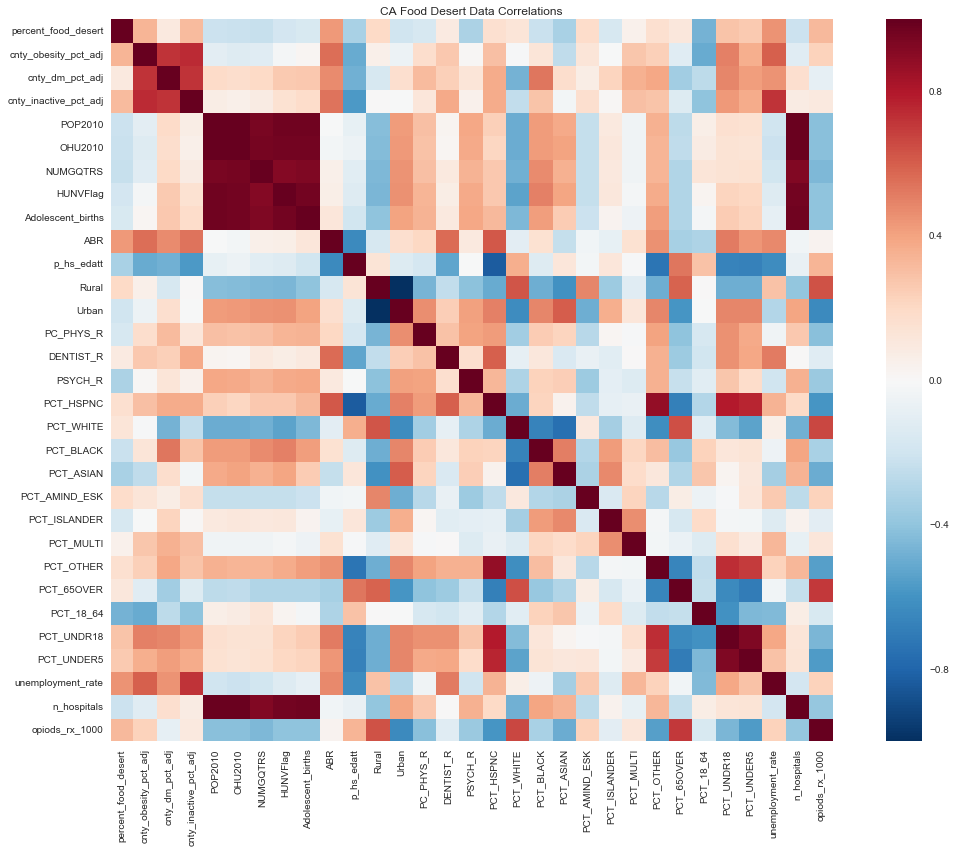

In [33]:
slim = df[['percent_food_desert','cnty_obesity_pct_adj','cnty_dm_pct_adj','cnty_inactive_pct_adj','POP2010','OHU2010','NUMGQTRS','HUNVFlag','Adolescent_births','ABR','p_hs_edatt','Rural','Urban','PC_PHYS_R','DENTIST_R','PSYCH_R','PCT_HSPNC',
 'PCT_WHITE',
 'PCT_BLACK',
 'PCT_ASIAN',
 'PCT_AMIND_ESK',
 'PCT_ISLANDER',
 'PCT_MULTI',
 'PCT_OTHER',
 'PCT_65OVER',
 'PCT_18_64',
 'PCT_UNDR18',
 'PCT_UNDER5','unemployment_rate',
 'n_hospitals','opiods_rx_1000']]
slim
corrmat = slim.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [34]:
des = df[df['percent_food_desert'] >= .1]
not_des = df[df['percent_food_desert'] < .1]
des_mean=des['opiods_rx_1000'].mean()
not_des_mean=not_des['opiods_rx_1000'].mean()

In [35]:
print "Food desert counties Opioid Rx mean", des_mean
print "NON-food desert counties Opioid Rx mean", not_des_mean

print "Effect size: ", abs(des_mean - not_des_mean)

Food desert counties Opioid Rx mean 1020.60758621
NON-food desert counties Opioid Rx mean 806.059310345
Effect size:  214.548275862


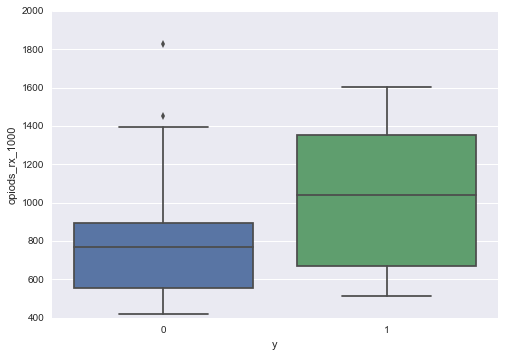

In [36]:
# sns.distplot(des['opiods_rx_1000'])
# sns.distplot(not_des['opiods_rx_1000'])
plt.show()
df['y'] = df['percent_food_desert'] >= .1
df['y'] =df['y'].astype(int)
ax = sns.boxplot(x="y", y="opiods_rx_1000", data=df)


In [37]:
groupby_des = df.groupby('y')
for cat, value in groupby_des['opiods_rx_1000']:
    print((cat, value.mean()))

(0, 806.0593103448275)
(1, 1020.6075862068964)


In [38]:
import scipy.stats as stats
groupby_des.mean()
stats.ttest_1samp(df['opiods_rx_1000'], 0)  

Ttest_1sampResult(statistic=19.799750388279346, pvalue=3.1848902723184858e-27)

With a p-value of 3^-27 we can claim that the population mean for the opioid prescriptions in CA is not 0.  

We have seen above that the mean number of opioid prescriptions per 1000 citizens in the food desert and non_food_desert counties were different. To test if this is significant, we do a 2-sample t-test with scipy.stats.ttest_ind():

In [39]:
des_rx = des['opiods_rx_1000']
non_des_rx = not_des['opiods_rx_1000']
stats.ttest_ind(des_rx, non_des_rx)  

Ttest_indResult(statistic=2.4228635455579957, pvalue=0.01865761673800884)

with a p value < than 0.05, we conclude there is a statistically significant difference in opiod prescriptions between counties with a high and low prevelances of food deserts

Bayesian Approach
---

In [43]:
from pymc import rbeta


class Discharges(object):

    """
    This class represents N discharge dispositions.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        dc( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def dc(self, i):
        # i is which arm to dc
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        discharges: a Discharges class with .dc method
    
    methods:
        sample_discharges(n): sample and train on n dc.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, discharges):

        self.discharges = discharges
        n_discharges = len(self.discharges)
        self.wins = np.zeros(n_discharges)
        self.trials = np.zeros(n_discharges)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_discharges(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the discharges's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen discharge
            result = self.discharges.dc(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [45]:
from IPython.core.pylabtools import figsize

figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d Discharges" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

In [51]:
# dc_readmits= df[['discharge_disposition_id','readmitted_<30']].groupby('discharge_disposition_id').agg(np.sum).reset_index() #'readmitted_<30'columns.tolist()

# dc_counts= df[['discharge_disposition_id','encounter_id']].groupby('discharge_disposition_id').count().reset_index() #'readmitted_<30'columns.tolist()
# dcs=pd.merge(dc_readmits,dc_counts)
bayes= df[['POP2010','County','cnty_dm_pct','y']].copy()
bayes.groupby('y').mean()
bayes['cnty_dm_pct'] = bayes['cnty_dm_pct'] * .01
bayes['dm'] = bayes['cnty_dm_pct'] * bayes['POP2010']
bayes['dm'] =bayes['dm'].astype(int) 
bayes
fresno=bayes[bayes.County=='Fresno']
marin=bayes[bayes.County=='Marin']
fresno
marin
samps=bayes[bayes['County'].isin(['Marin','Fresno'])]
samps

POP2010  County  cnty_dm_pct  y     dm
9    930450  Fresno        0.090  1  83740
20   252409   Marin        0.055  0  13882

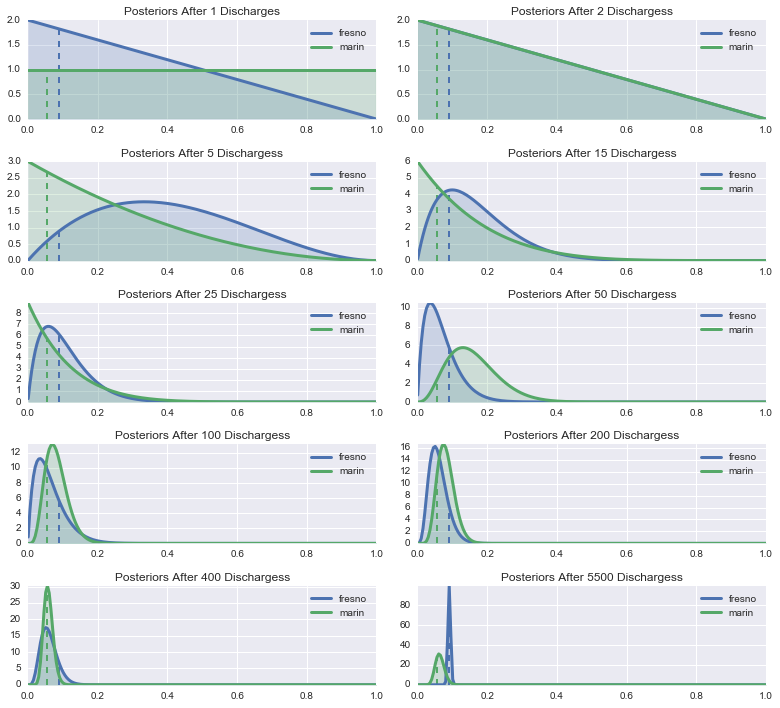

In [52]:
hidden_prob = samps['cnty_dm_pct'].values
discharges = Discharges(hidden_prob)
bayesian_strat = BayesianStrategy(discharges)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 5100]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_discharges(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.legend(labels=['fresno','marin'])#['home','rehab','LTC','nursing','psych']

    #plt.legend(labels=['home','SNF','home_health','AMA','hospice','psych'])#['home','rehab','LTC','nursing','psych']
    plt.autoscale(tight=True)
plt.tight_layout()

In [116]:
bayes= df[['POP2010','cnty_dm_pct','y']].copy()
bayes.groupby('y').mean()
bayes['cnty_dm_pct'] = bayes['cnty_dm_pct'] * .01
bayes['dm'] = bayes['cnty_dm_pct'] * bayes['POP2010']
bayes['dm'] =bayes['dm'].astype(int) 
bayes
sums=bayes.groupby('y').sum()
sums['POP2010'].ix[0]

non_des_pop = sums['POP2010'].ix[0]
non_des_dm = sums['dm'].ix[0]
des_pop =  sums['POP2010'].ix[1]
des_dm  = sums['dm'].ix[0]
sums

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

In [117]:
data_A = np.r_[[0] * (non_des_pop - non_des_dm), [1] * non_des_dm]
data_B = np.r_[[0] * (des_pop - des_dm), [1] * des_dm]
data_A

array([0, 0, 0, ..., 1, 1, 1])

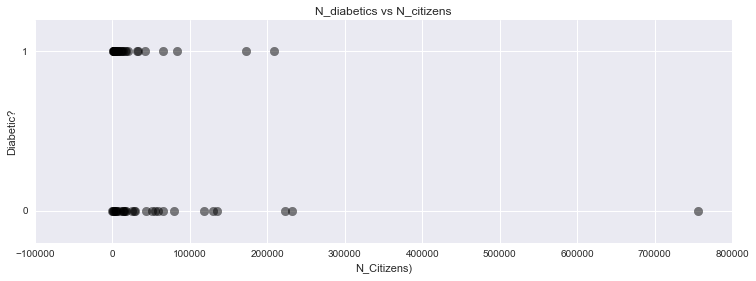

In [127]:
#bayes.groupby('y').sum()
# bayes.groupby('y').mean()
# obs = pm.Bernoulli('obs', p, value=data_B, observed=True)
# mcmc = pm.MCMC([p,obs])
# mcmc.sample(2000,1000)
bayes


plt.scatter(bayes['dm'], bayes['y'], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Diabetic?")
plt.xlabel("N_Citizens)")
plt.title("N_diabetics vs N_citizens")

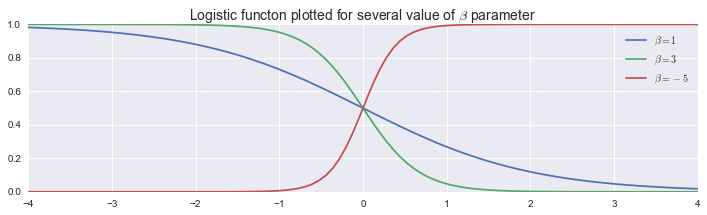

In [139]:

figsize(12, 3)


def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.title("Logistic functon plotted for several value of $\\beta$ parameter", fontsize=14)
plt.legend();

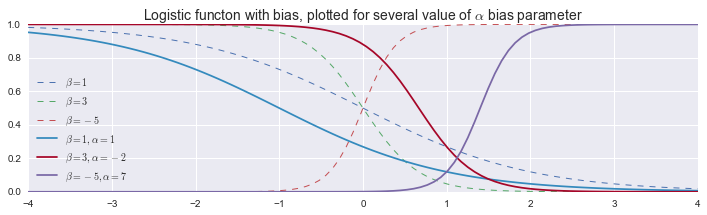

In [140]:

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title("Logistic functon with bias, plotted for several value of $\\alpha$ bias parameter", fontsize=14)
plt.legend(loc="lower left");

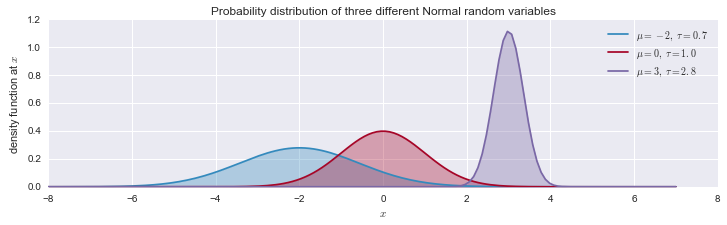

In [141]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

In [143]:
temperature = bayes['dm'].values
D = bayes['y'].values  # defect or not?

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [144]:
p.value


array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5])

In [145]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

# Mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 13.5 sec

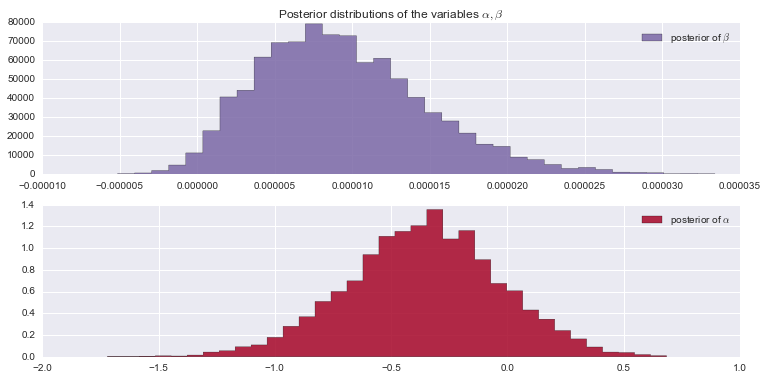

In [146]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [147]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

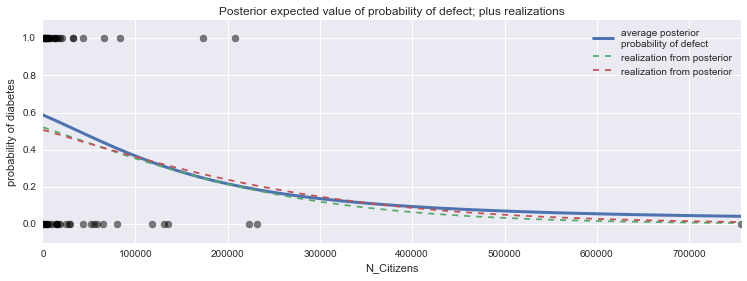

In [153]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="upper right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability of diabetes")
plt.xlabel("N_Citizens");

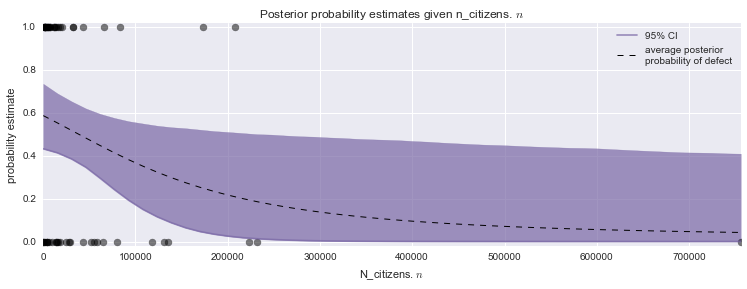

In [157]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("N_citizens. $n$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given n_citizens. $n$");

In [185]:
test = [x for x in bayes['POP2010']]

#x for x in df['']

test2 = list(df[df['POP2010'] == test[:]]['County'].values)
d = {}
for i in range(len(test2)):
    d[test2[i]] = test[i]
#test3 = {test2:test}
d

{'Alameda': 1510271,
 'Alpine': 1175,
 'Amador': 38091,
 'Butte': 220000,
 'Calaveras': 45578,
 'Colusa': 21419,
 'Contra Costa': 1049025,
 'Del Norte': 28610,
 'El Dorado': 181058,
 'Fresno': 930450,
 'Glenn': 28122,
 'Humboldt': 134623,
 'Imperial': 174528,
 'Inyo': 18546,
 'Kern': 839631,
 'Kings': 152982,
 'Lake': 64665,
 'Lassen': 34895,
 'Los Angeles': 9818605,
 'Madera': 150865,
 'Marin': 252409,
 'Mariposa': 18251,
 'Mendocino': 87841,
 'Merced': 255793,
 'Modoc': 9686,
 'Mono': 14202,
 'Monterey': 415057,
 'Napa': 136484,
 'Nevada': 98764,
 'Orange': 3010232,
 'Placer': 348432,
 'Plumas': 20007,
 'Riverside': 2189641,
 'Sacramento': 1418788,
 'San Benito': 55269,
 'San Bernardino': 2035210,
 'San Diego': 3095313,
 'San Francisco': 805235,
 'San Joaquin': 685306,
 'San Luis Obispo': 269637,
 'San Mateo': 718451,
 'Santa Barbara': 423895,
 'Santa Clara': 1781642,
 'Santa Cruz': 262382,
 'Shasta': 177223,
 'Sierra': 3240,
 'Siskiyou': 44900,
 'Solano': 413344,
 'Sonoma': 483878,


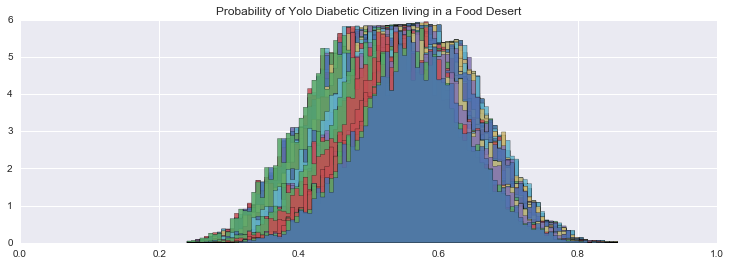

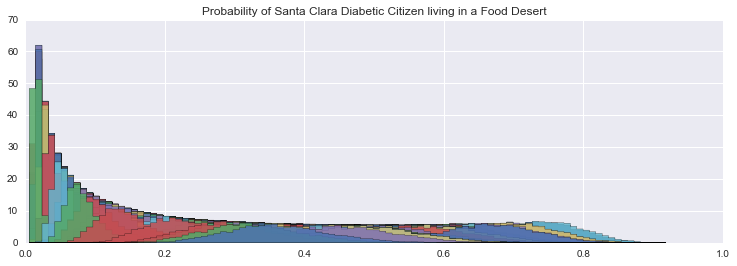

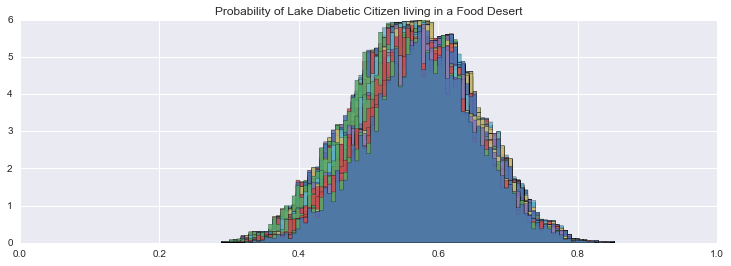

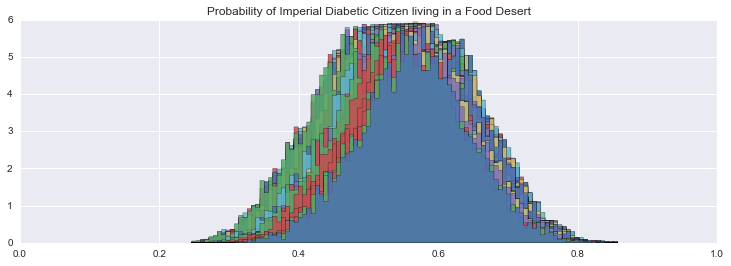

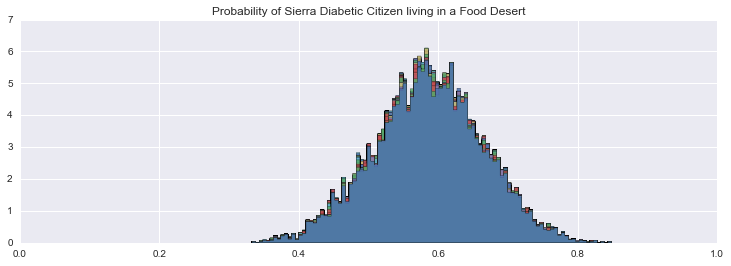

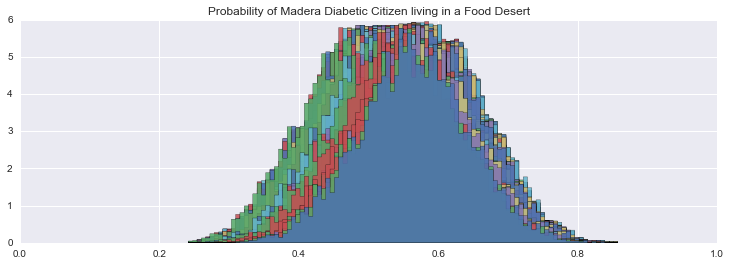

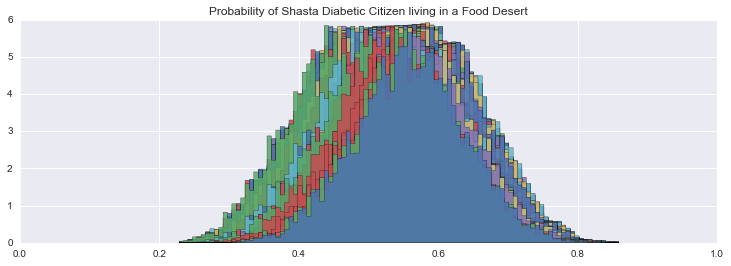

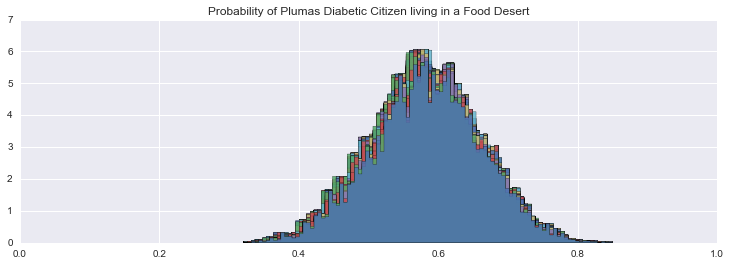

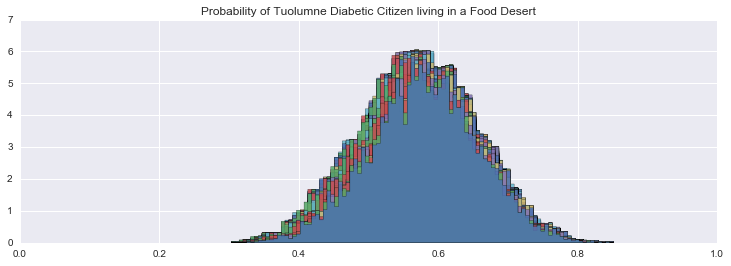

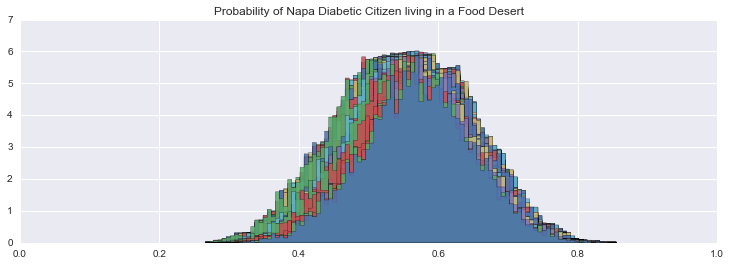

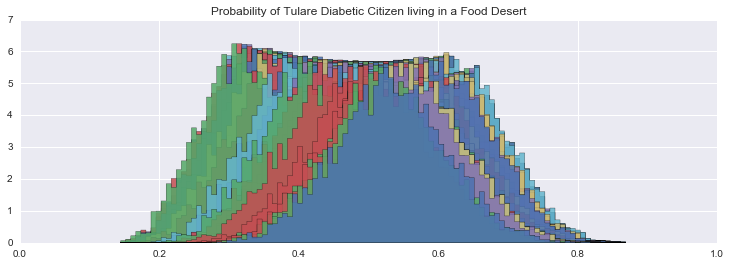

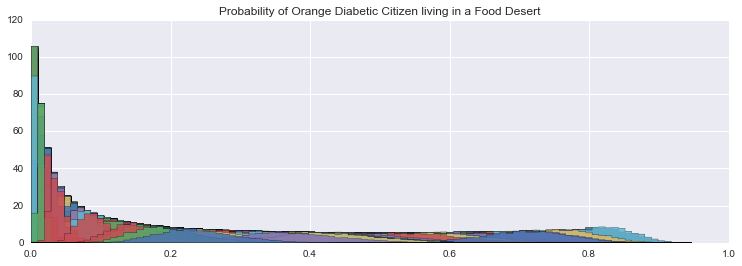

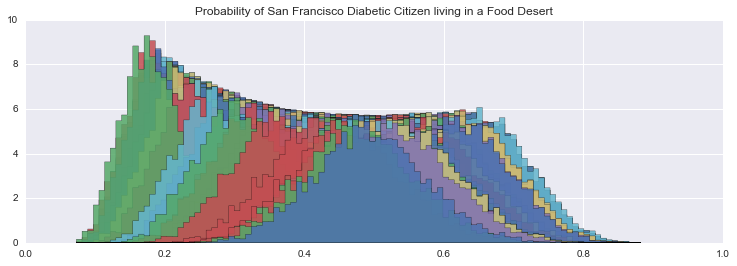

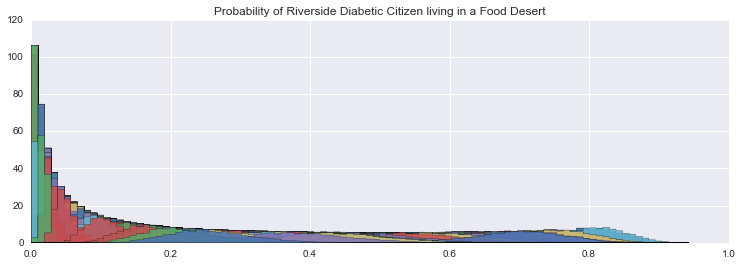

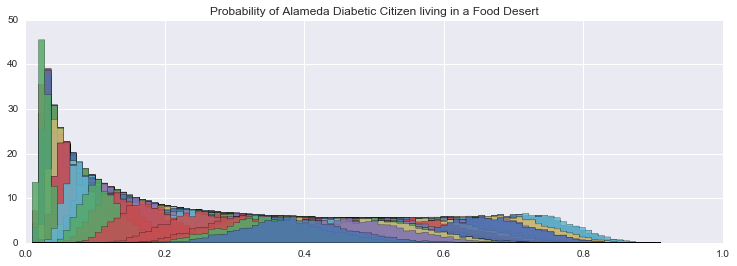

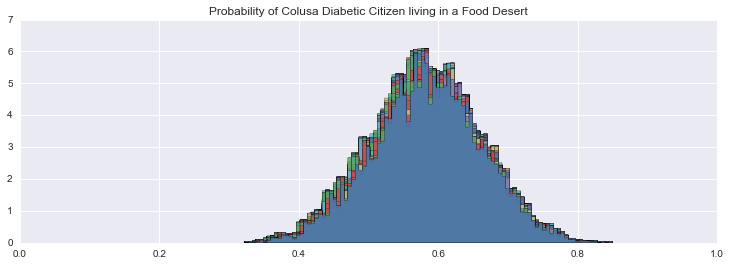

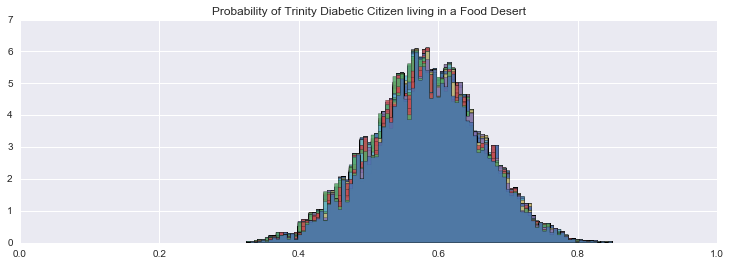

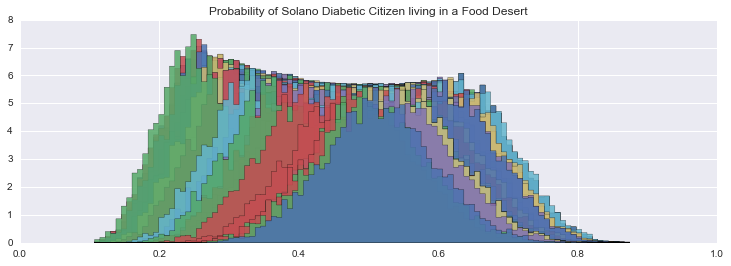

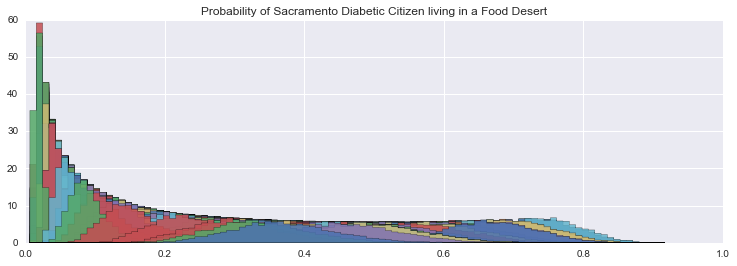

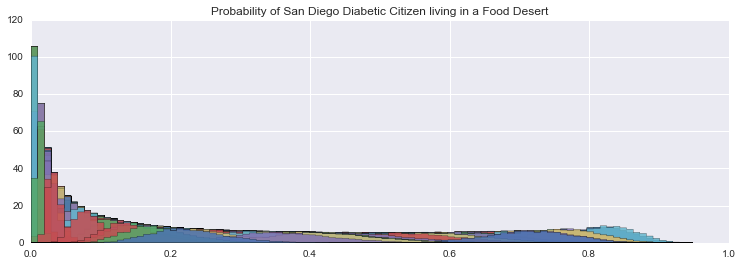

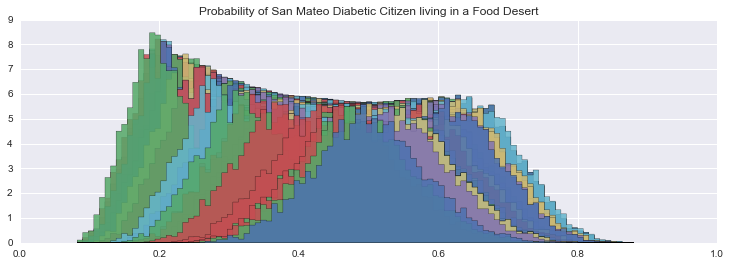

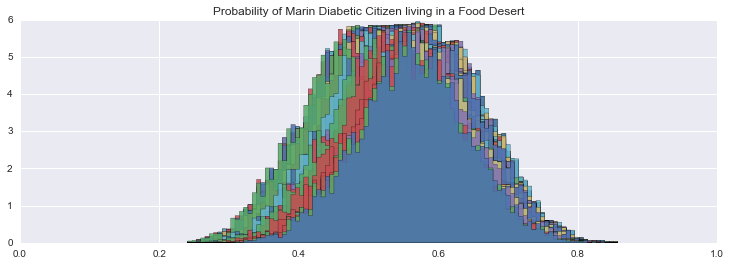

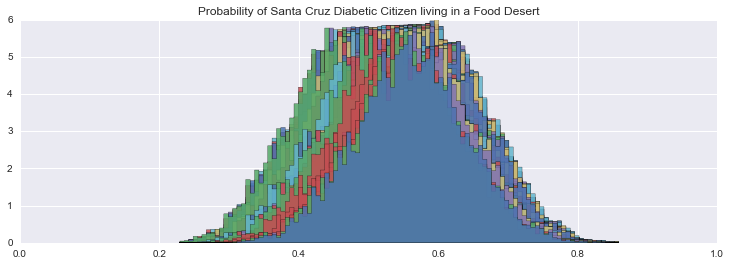

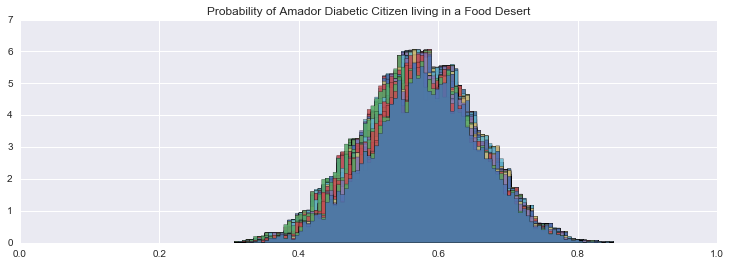

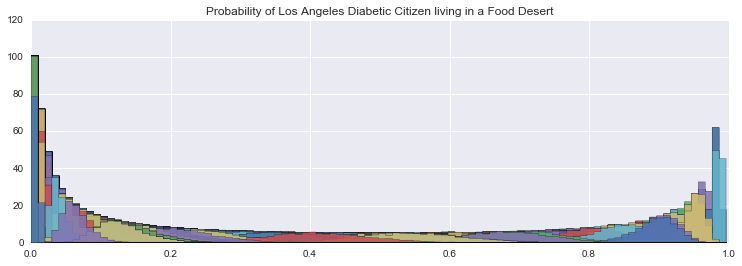

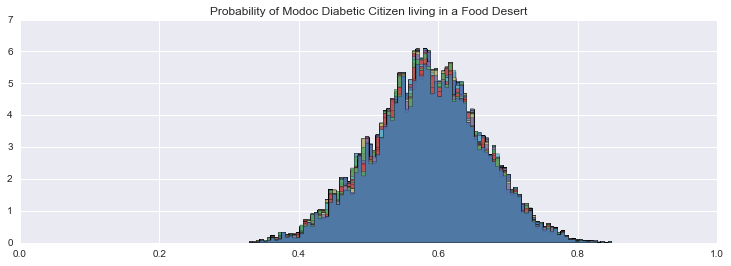

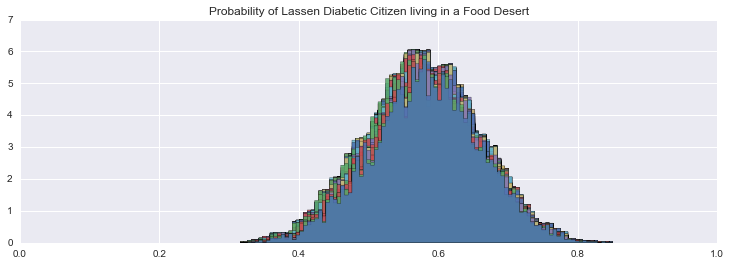

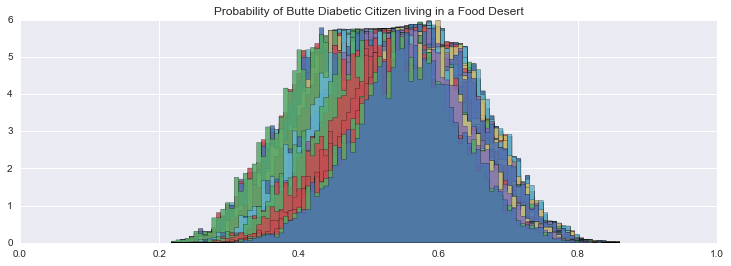

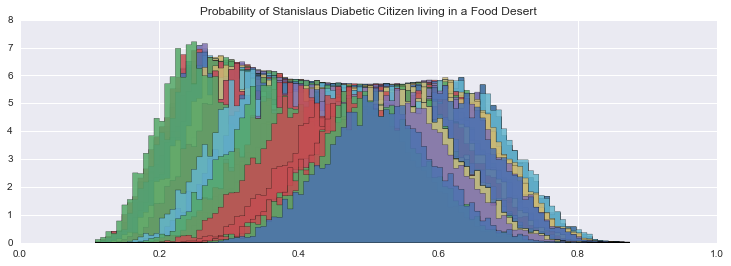

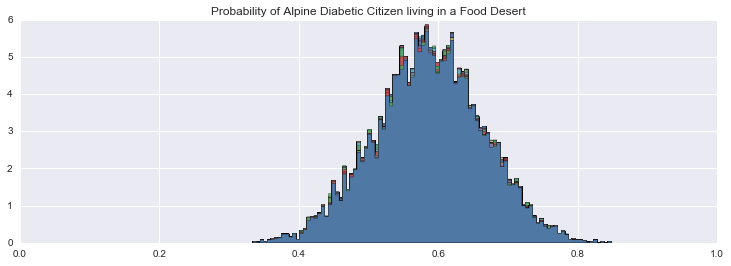

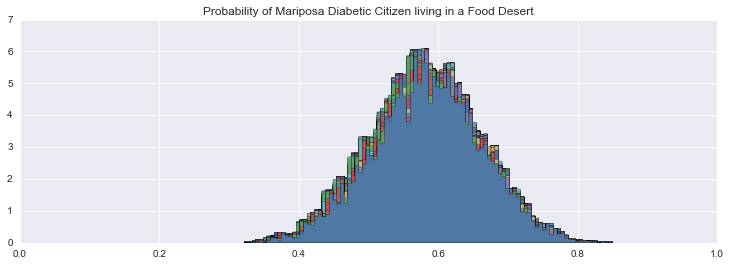

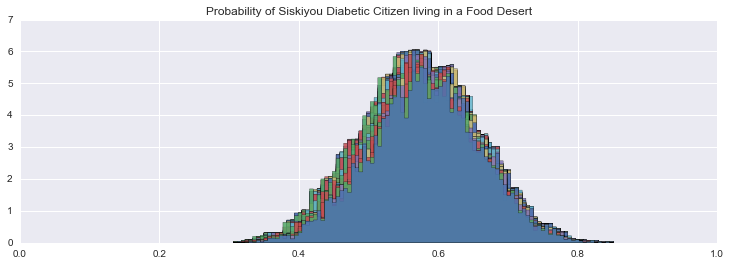

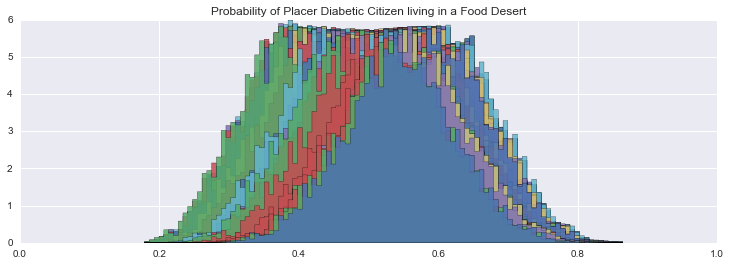

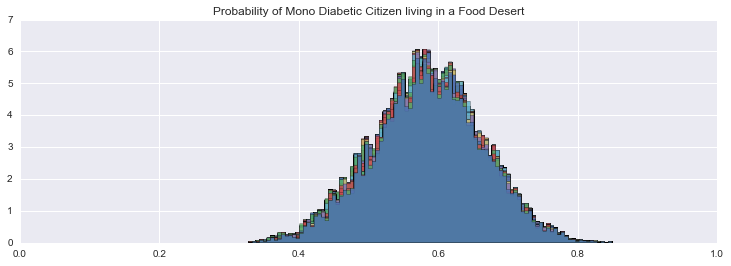

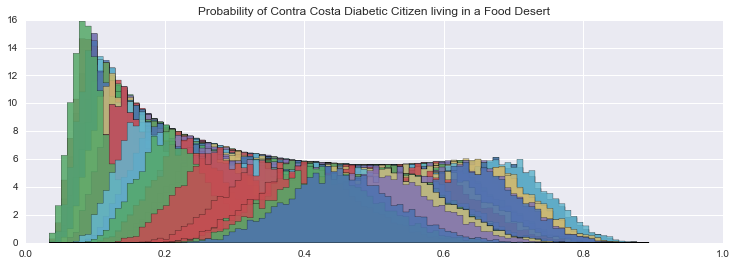

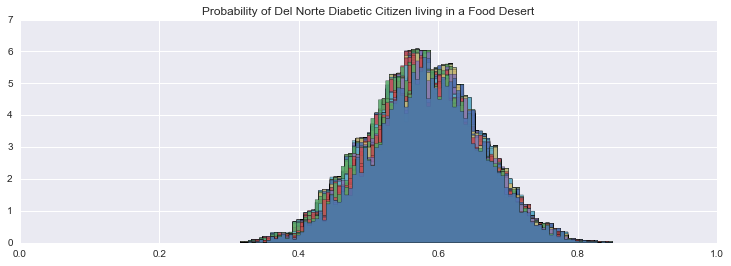

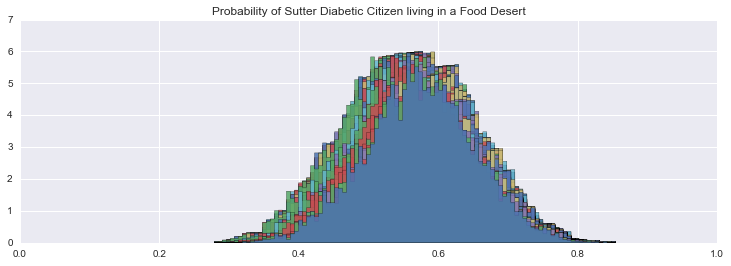

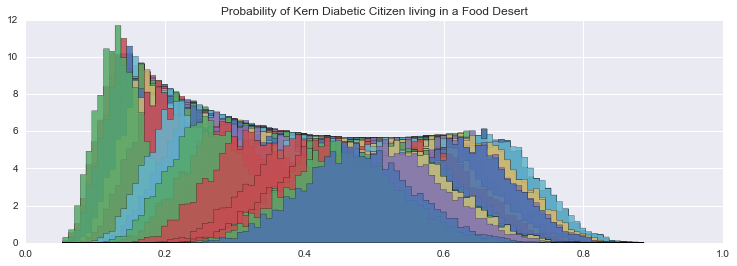

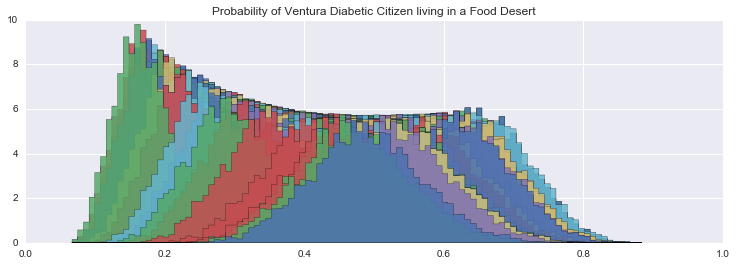

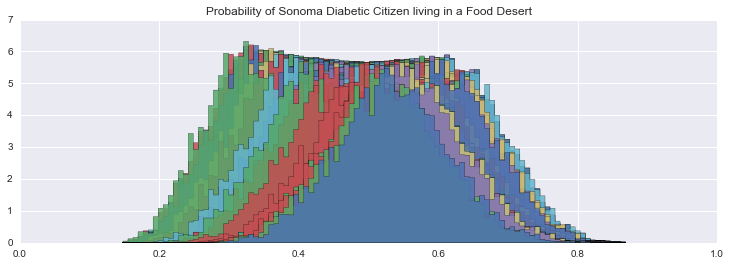

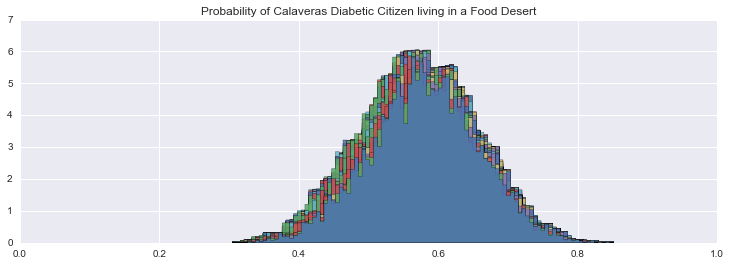

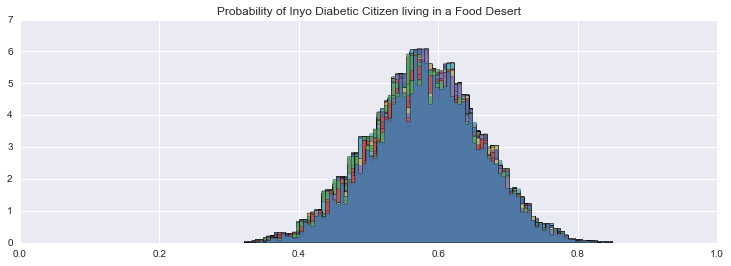

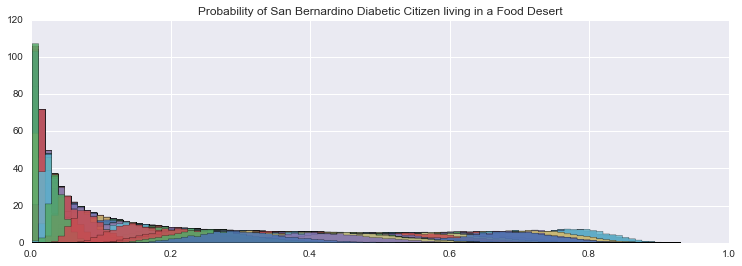

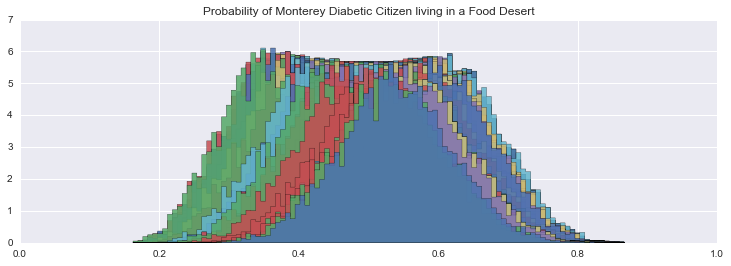

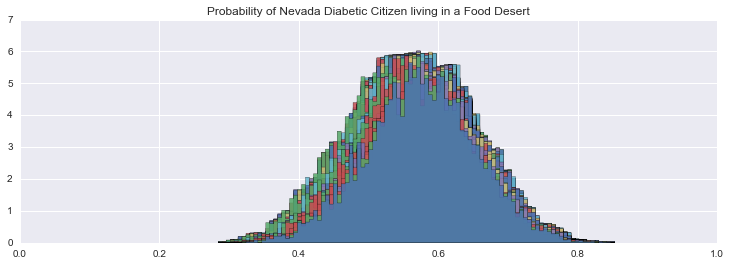

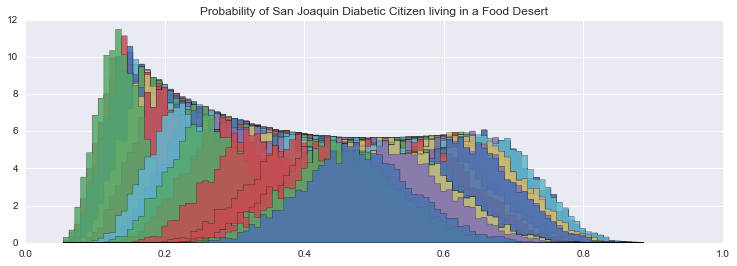

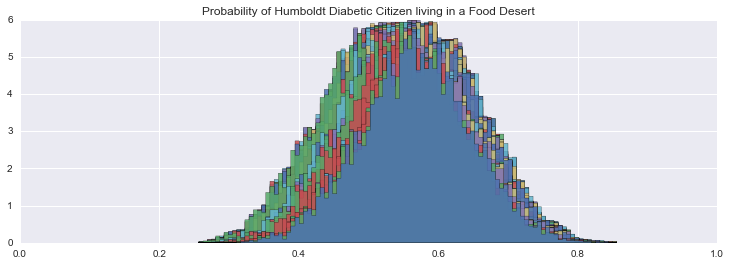

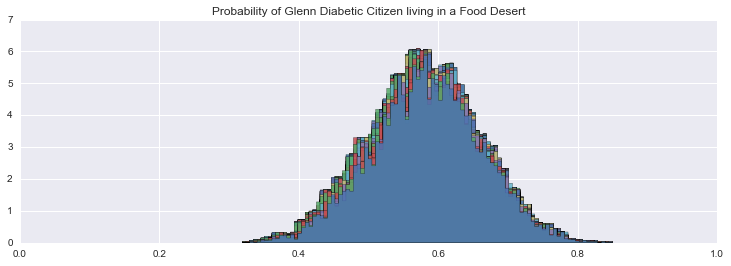

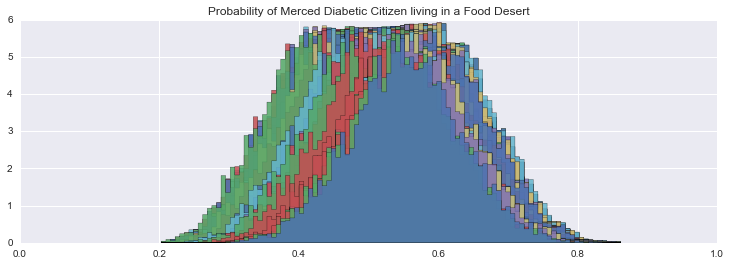

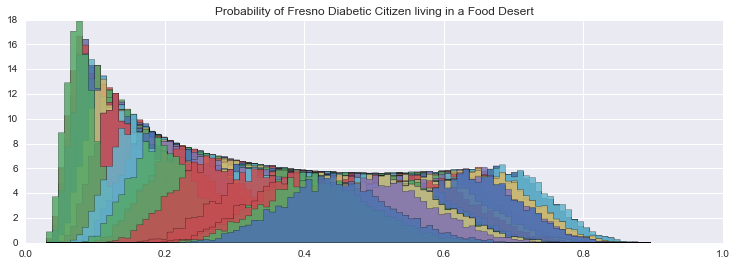

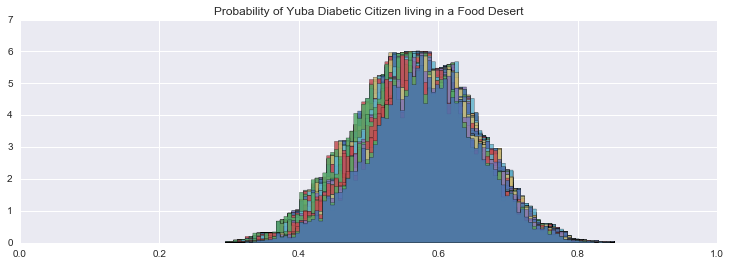

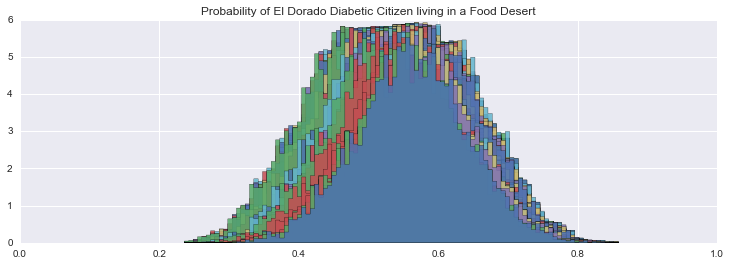

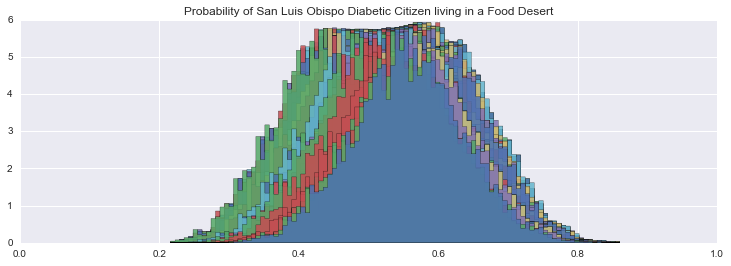

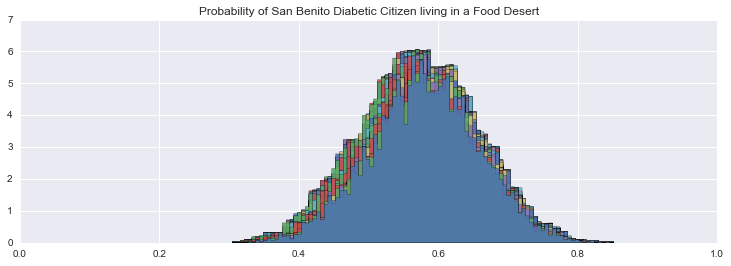

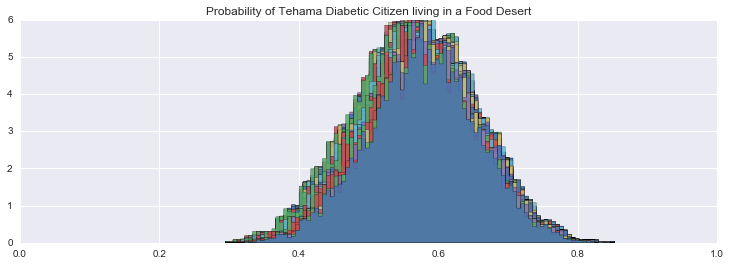

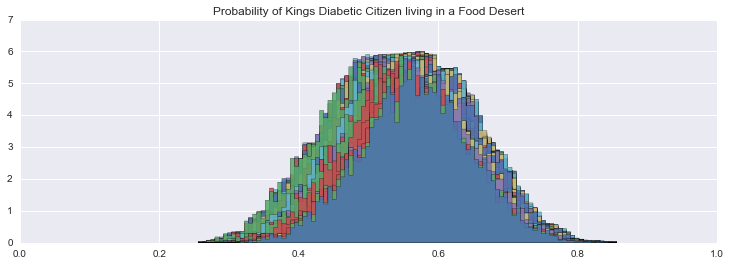

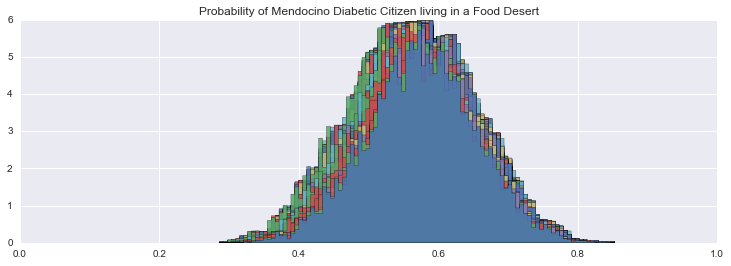

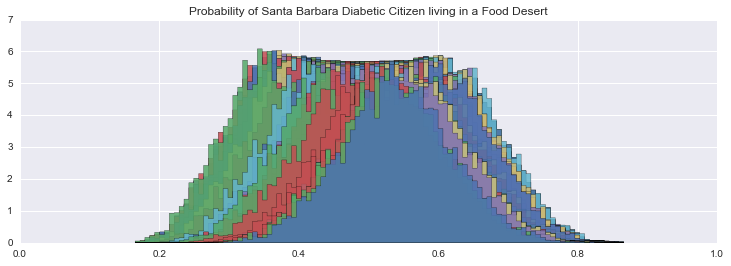

In [198]:
for i in d.keys():
    dm= bayes[bayes['POP2010'] == d[i]]['dm']
    prob_county = logistic(dm, beta_samples, alpha_samples)
    plt.xlim(0,1)
    plt.hist(prob_county, histtype='stepfilled', bins=100, normed=True, alpha=0.25)
    plt.title('Probability of {0} Diabetic Citizen living in a Food Desert'.format(i))
    plt.legend()
    plt.show()


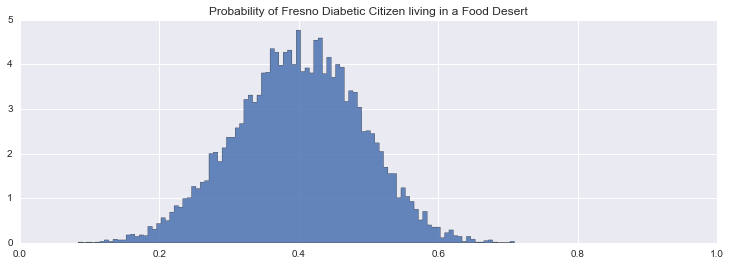

In [194]:
df[df['County'] == 'Fresno']['POP2010']#, 'cnty_dm_pct', 'y', 'dm']]
bayes[bayes['POP2010'] == 930450]
prob_fresno = logistic(83740, beta_samples, alpha_samples)
plt.xlim(0,1)
plt.hist(prob_fresno, histtype='stepfilled', bins=100, normed=True, alpha=0.85)
plt.title('Probability of Fresno Diabetic Citizen living in a Food Desert')
plt.legend()

# plt.subplot(212)
# plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
#          label=r"posterior of $\alpha$", color="#A60628", normed=True)
# plt.legend();
# #temperature[temperature == 83740]
# #bayes.columns.tolist()

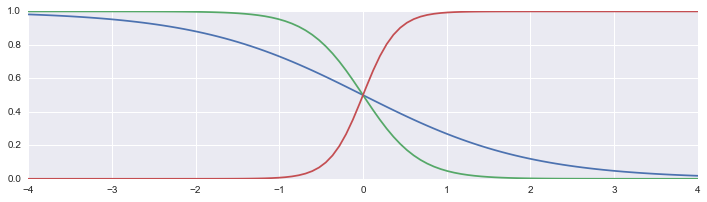

In [136]:
from IPython.core.pylabtools import figsize

figsize(12,3)

def logistic(x,beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta,x)+alpha))

x=np.linspace(-4,4,100)
plt.plot(x, logistic(x,1), label='1')
plt.plot(x,logistic(x,3), label='3')
plt.plot(x,logistic(x,-5), label='-5')


# plt.title('Posterior distributions of $p_DM$(unknown)')
# #plt.vlines(p_true, 0, 90, linestyle='--', title='$p_DM$(unknown)')
# plt.hist(mcmc.trace('p')[:], bins=35, histype='stepfilled',normed=True)
# plt.xlabel("Value of $p_fooddes$")
# plt.ylabel("density")

In [138]:
beta = pm.Normal('beta', 0 , 0.001, value=0)
alpha = pm.Normal('beta', 0 , 0.001, value=0)

@pm.deterministic
def p(pop=bayes['POP2010'], alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta*t + alpha))

p.value

NameError: global name 't' is not defined

In [115]:

# Bins of how many users clicked 1 time, 2 times, 3 times, ...
bins_A = bayes[bayes['y'] == 1]['dm']#[26912, 58046, 11846, 11295, 5499, 4965, 3266, 2869, 2283, 2062, 1706, 1541, 1348, 1340, 1096, 1062, 890, 849, 845, 734, 659, 584, 586, 570, 537, 554, 505, 502, 439, 421, 437, 378, 342, 389, 356, 333, 317, 298, 348, 296, 328, 287, 314, 269, 289, 260, 252, 256, 15434]
bins_B = bayes[bayes['y'] == 0]['dm']#[26298, 58229, 11656, 11292, 5427, 5073, 3353, 3018, 2319, 2039, 1770, 1581, 1406, 1234, 1096, 1032, 919, 902, 852, 757, 710, 660, 568, 619, 573, 521, 497, 506, 477, 427, 398, 394, 373, 355, 365, 340, 300, 338, 304, 301, 298, 302, 283, 255, 263, 268, 232, 214, 15700]
clicks = range(1, len(bins_A))

# Start with uniform probability over the bins
# p_A = pm.Dirichlet("p_A", theta=np.ones(len(bins_A)))
# p_B = pm.Dirichlet("p_B", theta=np.ones(len(bins_B)))
p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

# A multimodal dist. using the probabilitys of bins
obs_A = pm.Poisson("obs_A", mu=27485.034483, value=bins_A, observed=True)
obs_B = pm.Poisson("obs_B", mu=73722.758621, value=bins_B, observed=True)
['mu', 'value', 'observed', 'size', 'trace', 'rseed', 'doc', 'debug', 'plot', 'verbose']


@pm.deterministic
def percent_better(p_B=p_B, p_A=p_A, clicks=clicks):
    """
    By multiplying each bins probability with 
    what that bin is worth (number of clicks)
    and the summing,
    we get the expected number of clicks (right?).

    We then calculate the lift of B over A in percent
    """
    exp_clicks_B = np.dot(p_B.astype(float)/sum(p_B), clicks)
    exp_clicks_A = np.dot(p_A.astype(float)/sum(p_A), clicks)

    return ((exp_clicks_B / exp_clicks_A) - 1)*100.0

model = pm.Model([p_A, p_B, 
                  obs_A, obs_B, 
                  percent_better])

map_ = pm.MAP(model)
map_.fit() 
mcmc = pm.MCMC(model)
mcmc.sample(120000, burn=20000)

percent_better_samples = mcmc.trace("percent_better")[:]

print "Probability B > A: {}".format((percent_better_samples > 0).mean())
print "Confidence interval of B:s lift over A:"
print np.percentile(percent_better_samples, 2.5)
print np.percentile(percent_better_samples, 97.5)


TypeError: iteration over a 0-d array

In [105]:
import pymc 

def linear_setup(df, ind_cols, dep_col):
    '''
        Inputs: pandas Data Frame, list of strings for the independent variables,
        single string for the dependent variable
        Output: PyMC Model
    '''
    
    # model our intercept and error term as above
    b0 = pymc.Normal("b0", 0, 0.0001)
    err = pymc.Uniform("err", 0, 500)
    
    # initialize a NumPy array to hold our betas 
    # and our observed x values
    b = np.empty(len(ind_cols), dtype=object)
    x = np.empty(len(ind_cols), dtype=object)
    
    # loop through b, and make our ith beta
    # a normal random variable, as in the single variable case
    for i in range(len(b)):
        b[i] = pymc.Normal("b" + str(i + 1), 0, 0.0001)
        
    # loop through x, and inform our model about the observed
    # x values that correspond to the ith position
    for i, col in enumerate(ind_cols):
        x[i] = pymc.Normal("x" + str(i + 1), 0, 1, value=np.array(df[col]), observed=True)
    
    # as above, but use .dot() for 2D array (i.e., matrix) multiplication
    @pymc.deterministic
    def y_pred(b0=b0, b=b, x=x):
        return b0 + b.dot(x)
    
    # finally, "model" our observed y values as above
    y = pymc.Normal("y", y_pred, err, value=np.array(df[dep_col]), observed=True)
    
    return pymc.Model([b0, pymc.Container(b), err, pymc.Container(x), y, y_pred])

test_model = linear_setup(df, ['y','POP2010' ], 'cnty_dm_pct')
mcmc = pymc.MCMC(test_model)
mcmc.sample(100000, 20000)

# def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
#     """
#     This function accepts the number of upvotes and downvotes a particular comment received, 
#     and the number of posterior samples to return to the user. Assumes a uniform prior.
#     """
#     N = upvotes + downvotes
#     upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
#     observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
#     # do the fitting; first do a MAP as it is cheap and useful.
#     map_ = pm.MAP([upvote_ratio, observations]).fit()
#     mcmc = pm.MCMC([upvote_ratio, observations])
#     mcmc.sample(samples, samples / 4)
#     return mcmc.trace("upvote_ratio")[:]

# test = posterior_upvote_ratio(des_pop, des_dm, samples=20000)


# y1 = np.array( bayes[bayes['y'] == 1]['dm'].values )
# y2 = np.array( bayes[bayes['y'] == 0]['dm'].values )
# y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['des']*len(y1), ['nondes']*len(y2)]))
# y
# y.hist('value', by='group');
# y


/Users/desert/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 100000 of 100000 complete in 27.5 sec

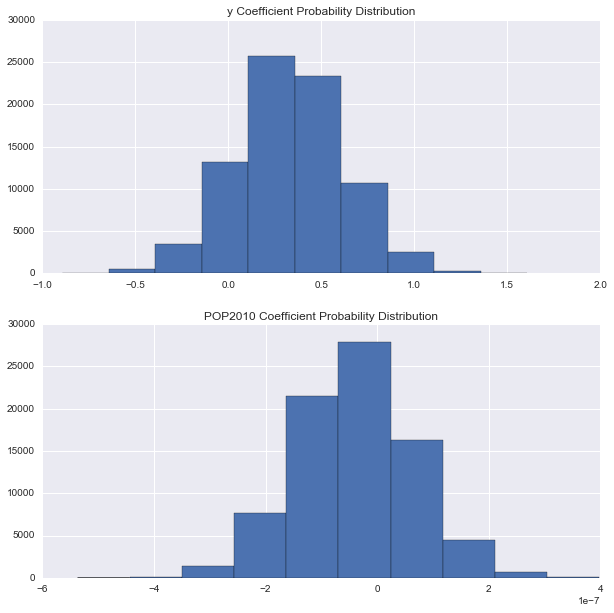

In [106]:
multifig, multiax = plt.subplots(2, 1, figsize=(10, 10))
b_nought = mcmc.trace("b0")[:]
b_y = mcmc.trace("b1")[:]
b_pop = mcmc.trace("b2")[:]

multiax[0].hist(b_y)
multiax[0].set_title("y Coefficient Probability Distribution")
multiax[1].hist(b_pop)
multiax[1].set_title("POP2010 Coefficient Probability Distribution")

In [107]:
print "Intercept: " + str(np.mean(b_nought)) 
print "MD ratio Coefficient: " + str(np.mean(b_y)) 
print "Af_amr Coefficient: " + str(np.mean(b_pop))

Intercept: 7.93729840228
MD ratio Coefficient: 0.331776337163
Af_amr Coefficient: -3.88885588143e-08


The observed diabetes rates are 22.9% and 23.95% for NON_desert counties and desert counties, respectively, but I'd like to be confident that the true diabetes rate of desert counties is higher than NON_desert counties.

To format this data for the analysis, I create a numpy array for each group with 1s representing diabetics and 0s representing nondiabetic citizens:

In [73]:
data_A = np.r_[[0] * (non_des_pop - non_des_dm), [1] * non_des_dm]
data_B = np.r_[[0] * (des_pop - des_dm), [1] * des_dm]

Next I assign distributions to my prior beliefs of p_A and p_B, the unknown, true diabetes rates. I assume, for simplicity, that the distributions are uniform (i.e. I have no prior knowledge of what p_A and 'p_B' are). 

In [74]:
import pymc as pm

p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

Since I want to estimate the difference in true diabetes rates, I need to define a variable delta, which equals p_B - p_A. Since, if I know both p_A and p_B, I can calculate delta, it's a deterministic variable. In PyMC, deterministic variables are created using a function with a pymc.deterministic wrapper:

In [75]:
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_B - p_A

Next I add the observed data to PyMC variables and run an inference algorithm

In [76]:
obs_A = pm.Bernoulli("obs_A", p_A, value = data_A, observed = True)
obs_B = pm.Bernoulli("obs_B", p_B, value = data_B, observed = True)


In [77]:
# #plt.hist(data_B)
# # Generate some random normal data
# group1 = bayes[bayes['y'] == 1]['dm'].values 
# group2 = bayes[bayes['y'] == 0]['dm'].values

# # Generate Pooled Data
# pooled = np.concatenate((group1,group2)) 

# #plt.hist(bayes['dm'])
# #sns.distplot(bayes[bayes['y'] == 1]['dm']) # Poisson
# #sns.distplot(bayes[bayes['y'] == 0]['dm'])# Poisson

# # Setup our priors
# mu1 = pm.Poisson("mu_1",mu=pooled.mean(), tau=1.0/pooled.var()/len(pooled))  
# mu2 = pm.Poisson("mu_2",mu=pooled.mean(), tau=1.0/pooled.var()/len(pooled))
# mu2
# # sig1 = pm.Uniform("sigma_1",lower=pooled.var()/1000.0,upper=pooled.var()*1000)  
# # sig2 = pm.Uniform("sigma_2",lower=pooled.var()/1000.0,upper=pooled.var()*1000)

# # v = pm.Exponential("nu",beta=1.0/29) 

In [86]:
data_A
print 'Probability NON Food desert resident being diabetic = %.0f%%', (np.mean(data_A) * 100)
print 'Probability Food desert resident being diabetic = %.0f%%', (np.mean(data_B) * 100)

Probability NON Food desert resident being diabetic = %.0f%% 7.67385850116
Probability Food desert resident being diabetic = %.0f%% 22.7596156385


In [88]:

def run_exp():
    # Generate 50 random binary variables with probability = 0.5
    test_a = stats.bernoulli(.5).rvs(50)
    test_b = stats.bernoulli(.5).rvs(50)

    for i in range(2, 50):
        # Run statistical t-test
        _, p = stats.ttest_ind(test_a[:i], test_b[:i])
        if p < 0.05:
            return True
        
    return False

p_sign_result = np.mean([run_exp() for i in range(1000)])

print 'Probability of getting significant result even though no\n difference exists = %.2f%%' % (p_sign_result * 100)

Probability of getting significant result even though no
 difference exists = 36.00%


Then I plot the posterior distributions for the three unknowns:

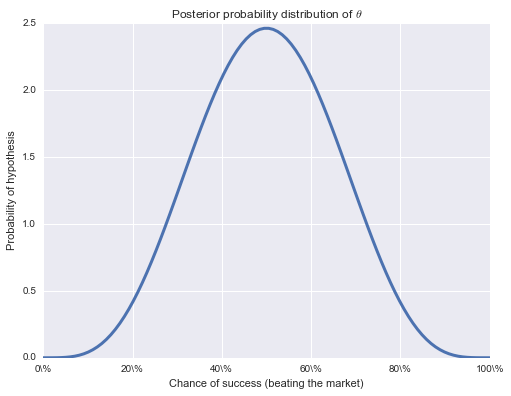

In [90]:
def gen_plot(success=(0, 100), failure=(0, 100)):
    alpha = 5 + success
    beta = 5 + success
    fig = plt.figure(figsize=(8, 6))
    x = np.linspace(0, 1, 100)
    ax = fig.add_subplot(111, xlabel='Chance of success (beating the market)', 
                         ylabel='Probability of hypothesis', 
                         title=r'Posterior probability distribution of $\theta$')
    ax.plot(x, stats.beta(alpha, beta).pdf(x), linewidth=3.)
    ax.set_xticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%']);
    
gen_plot(0, 0)

In [93]:
algo_a = stats.bernoulli(.5).rvs(300) # 50% profitable days
algo_b = stats.bernoulli(.6).rvs(300) # 60% profitable days
algo_a

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1])

In [94]:

import pymc as pm
model = pm.Model()
with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta_a = pm.Beta('theta_a', alpha=5, beta=5) # prior
    theta_b = pm.Beta('theta_b', alpha=5, beta=5) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('observed A',
                          p=theta_a, 
                          observed=algo_a)
    
    data_b = pm.Bernoulli('observed B', 
                          p=theta_b, 
                          observed=algo_b)
    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(10000, step, start=start, progressbar=False) # draw posterior samples using slice sampling 

AttributeError: __exit__

In [ ]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

ax = plt.subplot(311)

plt.xlim(0, .035)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
label="posterior of $p_A$", color="#A60628", normed=True,
edgecolor= "none")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta
unknowns")

ax = plt.subplot(312)

plt.xlim(0, .035)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label="posterior of $p_B$", color="#467821", normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.ylim(0,120)
plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.85,
        label="posterior of $p_B$ - $p_A$", color="#7A68A6",normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")
plt.vlines(0, 0, 120, color="black", alpha = .5)

plt.show()

I can also compute the probability that the true diabetes rate of non desert counties, p_A, is better than the true diabetes rate of desert counties, p_B:

In [ ]:
print "Probability NON-desert counties is BETTER than desert counties: %.3f" %
(delta_samples < 0).mean()
print "Probability NON-desert counties is WORSE than desert counties: %.3f" %
(delta_samples > 0).mean()

Frequenist Approach Linear Regression
----

1. Standardize variables (not doing so will cause us to mistake covariation for correlation)
     a measure of association that is affected by the scale of the variables 
2. 

In [ ]:
def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

# calculating r2 manually
mean_sum_squared_errors = np.sum((dataset['target']-dataset['target'].mean())**2)
regr_sum_squared_errors = np.sum((dataset['target']-fitted_values)**2)
r2 = (mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

# calculating r2 with scipy
(pearsonr(x_var, y_var)[0])**2

In [ ]:
stats.ttest_ind(df['percent_food_desert'], df['n_food_des'])  

The problem with this approach is that it forgets that there are links between observations: percent_food_desert and n_food_des are measured on the same counties. Thus the variance due to inter-subject variability is confounding, and can be removed, using a “paired test”, or “repeated measures test”:

In [ ]:
stats.ttest_rel(df['percent_food_desert'], df['n_food_des']) 
#This is equivalent to a 1-sample test on the difference:
#stats.ttest_1samp(df['percent_food_desert'] - df['n_food_des'], 0)   


T-tests assume Gaussian errors. We can use a Wilcoxon signed-rank test, that relaxes this assumption:

In [ ]:
stats.wilcoxon(df['percent_food_desert'], df['n_food_des']) 

Conclusion: we find that the data does support the hypothesis that counties with greater than 10% of the population living in a food desert and counties with less than 10% of the population living in a food desert have different consumptions of prescription opiods.

In [ ]:
model = smf.ols('percent_food_desert ~ opiods_rx_1000 + Urban', df).fit()
model.summary()

In [ ]:
sns.pairplot(df, vars=['percent_food_desert', 'opiods_rx_1000', 'ABR', 'Rural'],kind='reg', hue='y')  

In [ ]:

stats.ttest_1samp(des_mean, not_des_mean)
stats.shapiro(des['opiods_rx_1000'])
stats.shapiro(not_des['opiods_rx_1000'])

In [ ]:
import pymc

In [ ]:
# Website A had 1055 clicks and 28 sign-ups
values_A = np.hstack(([0]*(des['pop2010_in_des'].values-des['opiods_rx_1000'].values),[1]*(des['opiods_rx_1000'].values)))
# Website B had 1057 clicks and 45 sign-ups
values_B = np.hstack(([0]*(1057-45),[1]*45))
des[['pop2010_in_des','opiods_rx_1000']]
values_A

In [ ]:
def corrcoeff(frame1,var1,var2):
    frame = frame1.copy()
    frame['corrn']=(frame[var1]-np.mean(frame[var1]))*(frame[var2]-np.mean(frame[var2]))
    frame['corrd1']=(frame[var1]-np.mean(frame[var1]))**2
    frame['corrd2']=(frame[var2]-np.mean(frame[var2]))**2
    corrcoeffn=frame.sum()['corrn']
    corrcoeffd1=frame.sum()['corrd1']
    corrcoeffd2=frame.sum()['corrd2']
    corrcoeffd=np.sqrt(corrcoeffd1*corrcoeffd2)
    corrcoeff=corrcoeffn/corrcoeffd
    return corrcoeff

corrcoeff(df,'percent_food_desert','Urban')
corrcoeff(df,'percent_food_desert','Rural')

In [ ]:
plt.plot(df['Rural'],df['percent_food_desert'],'ro')
plt.title('Urban vs percent_food_desert')